# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.cm as cm
from scipy.linalg import eigh_tridiagonal
from scipy.fft import fft, fftfreq
from scipy.optimize import minimize
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
def transform(N=None, f=None, default=True):                                        # Contains all the information of the orthogonal transformation
  if default:                                                                       # For an analytic homogeneous coupling
    Lambda = np.zeros((N, N))
    S = np.zeros((N, N))                                                            # Transformation matrix
    for i in range(N):
      norm_cst = np.sqrt(np.sum([(np.sin((i+1)*(k+1)*np.pi/(N+1)))**2
                                 for k in range(N)]))                               # Normalization factor
      for j in range(N):
        S[i,j] = np.sin((i+1)*(j+1)*np.pi/(N+1))/norm_cst
        Lambda[i,j] = 2*np.cos(np.pi*(i+1)/(N+1)) + 2*np.cos(np.pi*(j+1)/(N+1))     # Matrix with all possible sums of eigenvalues
    eigenvalues = np.array([2*np.cos(np.pi*(i+1)/(N+1)) for i in range(N)])         # List with eigenvalues
  else:                                                                             # For a custom coupling profile
    N = len(f) + 1
    Lambda = np.zeros((N, N))
    eigenvalues, S = eigh_tridiagonal(np.zeros(N), f, check_finite=False)           # Numerical eigenvalues and eigenvectors
    eigenvalues = eigenvalues[::-1]                                                 # Ordering eigenvalues from largest to smalesst
    S = S[:, ::-1]                                                                  # Ordering eigenvectors according to eigenvalues
    for i in range(N):
      for j in range(N):
        Lambda[i,j] = eigenvalues[i] + eigenvalues[j]
  return S, Lambda, eigenvalues

def eta(N=None, profile_type='all', l=None, pump=None, default=True):               # Unit vector eta
  if default:
    if profile_type == 'all':
      return [1 for i in range(N)] / np.sqrt(N)                                     # Homogeneous injection
    elif profile_type == 'one':                                                     # Injection in the waveguide number "l"
      if l is None:
        l = int((N + 1)/2)                                                          # Injection in the center if waveguide number is not specified
      return [1 if l - 1 == i else 0 for i in range(N)]
  else:
      return [j for j in pump] / np.sqrt(np.sum(np.abs(pump) ** 2))

def i2s(X_i, transf_data):                                                          # transforms from individual-mode basis to supermode basis
  S = transf_data[0]
  if isinstance(X_i, tuple):
    return tuple(S @ x_i @ S.transpose() for x_i in X_i)
  elif isinstance(X_i, np.ndarray):
    return S @ X_i @ S.transpose()

def s2i(X_s, transf_data):                                                          # transforms from supermode basis to individual-mode basis
  S = transf_data[0]
  if isinstance(X_s, tuple):
    return tuple(S.transpose() @ x_s @ S for x_s in X_s)
  elif isinstance(X_s, np.ndarray):
    return S.transpose() @ X_s @ S

def JSA(Q):                                                                         # calculates joint-spatial amplitude
  N = Q.shape[-1]
  return 2 ** (1 - np.eye(N) / 2) * Q

def Q_s(z, C0, g, alpha, pump_data, transf_data, add_matrices=False):               # solution in the supermode basis
  S, Lambda, eigenvalues = transf_data
  N = len(eigenvalues)

  P = np.diag(pump_data)
  P_s = i2s(P, transf_data)                                                         # Pump matrix in supermode basis
  T_s = np.exp(1j * C0 * Lambda * z / 2) * np.sinc(C0 * Lambda * z / (2 * np.pi))   # Phase matching matrix in supermode basis
  Q_s = 1j * z * g * alpha * P_s * T_s
  if add_matrices:
    return Q_s, T_s, P_s
  else:
    return Q_s

def corr(X):
  N = X.shape[-1]                                                                     # Correlation matrix
  norm =  np.sum(2 ** (np.eye(N) - 1) * np.abs(X) ** 2, axis=(-1, -2), keepdims=True) # Norm of state
  return np.abs(X) ** 2 / norm

def n(X):
  N = X.shape[-1]                                                                     # Normalized expectation value of number operator
  n = np.sum((1 + np.eye(N)) * np.abs(X) ** 2, axis=-1)
  return n / np.sum(n, axis=-1, keepdims=True)

def simulate(N, C0, g, alpha, L, pump_data, transf_data, basis='individual', points=200, add_matrices=False):
  z = np.linspace(0, L, points)[:, None, None] * np.ones((N, N))
  sol = Q_s(z, C0, g, alpha, pump_data, transf_data, add_matrices)
  if basis == 'individual':
    sol = s2i(sol, transf_data)
  if add_matrices:
    Q = sol[0]
  else:
    Q = sol
  K = JSA(Q)
  prob = n(K)
  corr_map = corr(K)

  if add_matrices:                                                                  # Returns matrix decomposition of Hadamard product
    return prob, corr_map, K, *sol[1:]
  else:
    return prob, corr_map

def create_target(N, indexes, vanishing=False):                                     # Creates target correlation matrix for optimization
  all_idx = [(i, j) for i in range(N) for j in range(N)]
  nonzero_idx = indexes
  zero_idx = [i for i in indexes if i not in nonzero_coeffs]
  if vanishing:
    nonzero_idx, zero_idx = zero_idx, nonzero_idx

  target = np.zeros((N, N))
  for pair in nonzero_idx:
    target[pair] = 1
  _ = np.sum(2 ** (np.eye(N) - 1) * target)

  return target / _

def merit(var, target, transf_data, N, basis='individual'):                         # Merit function for optimization
  N = int((len(var) - 1) / 2 )
  z = var[0]
  pump = var[1:]
  pump_data = eta(pump=[abs(pump[2 * i]) * np.exp(1j * pump[2 * i + 1]) for i in range(N)], default=False)
  Q = Q_s(z, C0=1, g=1, alpha=1, pump_data=pump_data, transf_data=transf_data)
  if basis == 'individual':
    Q = s2i(Q, transf_data)
  K = JSA(Q)
  corr_m = corr(K)

  merit = np.sum((corr_m - target) ** 2)
  return merit

def similarity(target, optimization):
  return np.sum(np.sqrt(target * optimization)) ** 2 / (np.sum(target) * np.sum(optimization))

# Simulation of direct problem

In [4]:
# User-defined parameters
N = 100                       # dimension of array, number of waveguides
C0 = 1                        # linear coupling constant
L = 10 / C0                   # propagation distance

g = 1                         # nonlinear constant
alpha = 1                     # magnitud of pump field vector
points = 200                  # number of points to simulate
z = np.linspace(0, L, points)

# Coupling profile data: default=True is homogeneous, set dafault=False for custom profile
f = [1  for i in range(N - 1)]                                  # homogeneous coupling profile
f = [np.sqrt((i + 1) * (N - 1 - i)) / 2  for i in range(N - 1)] # parabolic coupling profile
f = [np.sqrt(i + 1) for i in range(N - 1)]                      # square-root coupling profile
transf_data = transform(N, f, default=True)

# Pump profile data: default=True is flat, set default=False for custom profile
pump_amp = [1 if i % 2 == 0 else -1 for i in range(N)]                 # custom pump profile magnitude
pump_pha = [0 for i in range(N)]                                       # custom pump profile phase
pump = [i*np.exp(1j * j) for i, j in zip(pump_amp, pump_pha)]
pump_data = eta(N, profile_type='one', pump=pump, default=True)

# basis can be changed to 'supermode'
prob, corr_m = simulate(N, C0, g, alpha, L, pump_data, transf_data, basis='individual', points=points)

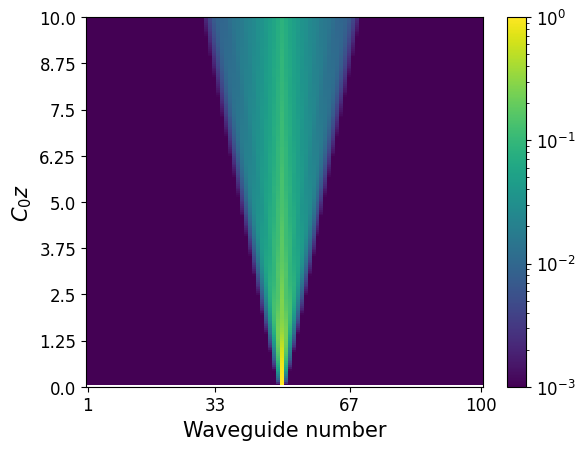

In [5]:
# Propagation plot
fig, ax = plt.subplots()
plt.pcolor(prob, norm=colors.LogNorm(vmin=1e-3, vmax=1))

try:
  test = prob[:, N-1]
  index = np.where(np.where(test > 1e-3, 0, 1) == 0)[0][0]
  if index > 10:
    plt.axhline(index, color='r')
except:
  pass
if N % 2 == 0:
  xticks = np.array([0.5, round(N/3) - 0.5, round(2*N/3) - 0.5, N - 0.5])
  xlabels = np.array([1, round(N/3), round(2*N/3), N])
else:
  xticks = np.array([0.5, round(N/4) + 0.5, N/2, round(3*N/4) - 0.5, N - 0.5])
  xlabels = xticks - N/ 2
plt.xticks(xticks, xlabels, fontsize=12)
plt.yticks(np.linspace(0, points, 9), np.round(C0*np.linspace(0, L, 9), 2), fontsize=12)

plt.xlabel('Waveguide number', fontsize=15)
plt.ylabel('$C_0z$', fontsize=15)
cbar = plt.colorbar()

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(axis='y', labelsize=12)

plt.show()

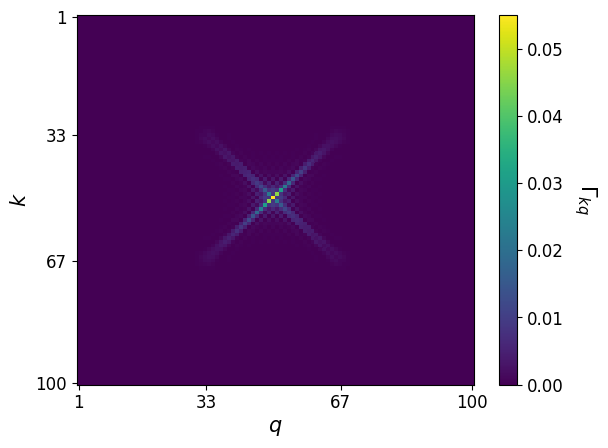

In [6]:
# Correlation matrix plot
fig, ax = plt.subplots()
plt.pcolor(corr_m[-1,:])

plt.xticks(xticks, xlabels, fontsize=12)
plt.yticks(xticks, xlabels, fontsize=12)
plt.xlabel('$q$', fontsize=15)
plt.ylabel('$k$', fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(axis='y', labelsize=12)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_ylabel('$\\Gamma_{{kq}}$', rotation=270, fontsize=15)
plt.gca().invert_yaxis()

plt.show()

# Optimization of inverse problem

In [ ]:
# User-defined parameters
N = 25
basis = 'individual'
L = 25
C0, g, alpha = 1        # These parameters can be set to one without loss of generality

# Coupling profile data: default=True is homogeneous, set dafault=False for custom profile
f = [np.sqrt((i + 1) * (N - 1 - i)) / 2  for i in range(N - 1)] # parabolic coupling profile
# f = [np.sqrt(i + 1) for i in range(N - 1)]                    # square-root coupling profile
transf_data = transform(N, f, default=True)

In [ ]:
# Target correlation matrix
optimization = 'odds'                               # Choose pre-defined target or make a custom one
show_target_plot = False                            # Show a plot of the target

if optimization == 'diagonal':
  nonzero_coeffs = [(i, j) for i in range(N) for j in range(N) if i == j]     # coefficients of correlation matrix that are nonzero
elif optimization == 'antidiagonal':
  nonzero_coeffs = [(i, j) for i in range(N) for j in range(N) if i == N - 1 - j]
elif optimization == 'odds':
  nonzero_coeffs = [(i, j) for i in range(N) for j in range(N) if i % 2 == 0 and j % 2 == 0]
elif optimization == 'evens':
  nonzero_coeffs = [(i, j) for i in range(N) for j in range(N) if i % 2 != 0 and j % 2 != 0]
elif optimization == 'same parity':
  nonzero_coeffs = [(i, j) for i in range(N) for j in range(N) if (i % 2 == 0 and j % 2 == 0) or (i % 2 != 0 and j % 2 != 0)]
elif optimization == 'custom':
  nonzero_coeffs = []

target = create_target(N, nonzero_coeffs)           # target correlation matrix

if show_target_plot:
  plt.pcolor(target, cmap='Blues')
  ticks = np.linspace(1, N, N, dtype='int')
  plt.xticks(ticks - 0.5, ticks)
  plt.yticks(ticks - 0.5, ticks)
  plt.gca().invert_yaxis()
  plt.colorbar()
  plt.show()

In [ ]:
# Optimization parameters
tol = 1e-8              # Tolerance, desired value for merit function
max_iterations = 10     # Maximum number of iterations
show_each = 5           # After how many iterations the progress is printed

# Optimization variable has dimension = 2 * N + 1 and
# has the form var = (z, |eta_1|, arg(eta_1), ..., |eta_N|, phi_N)

# Initial guess for z and pump profile
z_0 = [L / 2]
pump_0 = [1 / N if i % 2 == 0 else np.pi for i in range(2 * N)]
x0 = z_0 + pump_0

# bounds for z and pump profile:
# 0 < z < L
# 0 < |eta_j| < 1
# 0 < phi_j < 2 * pi
z_bound = [(0, L)]
pump_bound = [(0, 1) if i % 2 == 0 else (0, 2*np.pi) for i in range(2*N)]
bounds = z_bound + pump_bound

# random initial conditions generator
random_x0 = lambda: np.array([L*np.random.rand()] + [np.random.rand() if i % 2 == 0 else 2 * np.pi * np.random.rand() for i in range(2 * N)])

fun_values = []         # Merit function values list
opt_values = []         # Optimizations information list
iterations = 0          # Counter
perturbation = 0        # Perturbation order
min_fun = 1             # Minimum value from merit function values list

while min_fun > tol and iterations < max_iterations:
  iterations += 1
  res = minimize(merit, x0=x0, bounds=bounds, args=(target, transf_data, N, basis), options={'maxiter':500})
  if res['success']:
    opt_values.append(res)
    fun_values.append(res.fun)
    min_fun = np.min(fun_values)                                  # Overall best result
    i = np.argmin(fun_values)
    if len(fun_values) > 1 and fun_values[-1] < fun_values[-2]:   # Use result if last merit function is smaller than second to last value
      x0 = res.x + perturbation * np.random.randn(len(res.x))
    else:
      x0 = random_x0()                                            # Use random initial conditions in case the last result is not better
  else:
    x0 = random_x0()                                              # Use random initial conditions in case optimization was not successful
  if iterations % show_each == 0:
    print(f'{iterations} iterations and best optimization is {min_fun} so far...')

index_ref = np.argmin(fun_values)
res = opt_values[index_ref]
print(f'Total {iterations = }')
print(f'Successful iterations = {len(fun_values)}')
print(res)

5 iterations and best optimization is 1.133636493378313e-05 so far...
10 iterations and best optimization is 1.133636493378313e-05 so far...
Total iterations = 10
Successful iterations = 9
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1.133636493378313e-05
        x: [ 3.762e-02  2.738e-02 ...  3.102e-02  3.142e+00]
      nit: 54
      jac: [ 1.387e-06 -2.542e-06 ... -1.845e-08 -1.532e-09]
     nfev: 3640
     njev: 70
 hess_inv: <51x51 LbfgsInvHessProduct with dtype=float64>


In [ ]:
# Plot of fun values
plt.plot(np.log10(fun_values))
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Order of magnitude of merit function', fontsize=12)

In [ ]:
# Calculation of optimized correlation matrix
z = res['x'][0]
_ = res['x'][1:]
pump = [_[2 * i] * np.exp(1j * _[2 * i + 1]) for i in range(N)]
pump_data = eta(pump=pump, default=False)
amp = np.array([_[2 * i] for i in range(N)])
amp = amp / np.sqrt(np.sum(amp ** 2))
phase = [_[2 * i + 1] for i in range(N)]

# Prints the optimized position and pump profile
print(f'{z = }')
print('Amplitude:', *(str(x) + ',' for x in amp))
print('Phase:', *(str(x) + ',' for x in phase))
Q = Q_s(z, C0, g, alpha, pump_data, transf_data, add_matrices=False)
if basis == 'individual':
  Q = s2i(Q, transf_data)
corr_m = corr(JSA(Q))

z = 0.03762242982135676
Amplitude: 0.02709635414768624, 0.029402626496282926, 0.027157544940165375, 0.028914549644313427, 0.033051541188186845, 0.021723473943232235, 0.027163778821292117, 0.02046208873818785, 0.031873097926502655, 0.03610786477882426, 0.03063558198971821, 0.03016882932126311, 0.9896892155086768, 0.028321729576130744, 0.027051072871137553, 0.0216274784699317, 0.025926424634356734, 0.0374429666831517, 0.030738331048006138, 0.03610076394783623, 0.024853763792562204, 0.02890272234336534, 0.03054561078570835, 0.02830906079658968, 0.030696694058147664,
Phase: 3.1415791758479936, 3.1418245962568907, 3.1415408955208535, 3.141801622575151, 3.141446705345952, 3.1419096625158796, 3.1415316197932293, 3.141531199018881, 3.1416040650892674, 3.141596028284521, 3.141611885121893, 3.1415808670723875, 3.142657406281583, 3.141567209369502, 3.1416003871251417, 3.1417037124113367, 3.1416037548762636, 3.1416261209623237, 3.141599839213341, 3.1415139390568734, 3.141599443147683, 3.1414377298

In [ ]:
# Similariry between optimized matrix and target matrix
sim = similarity(target, corr_m)
print('The similarity between the correlation matrices is', round(sim, 3))

The similarity between the correlation matrices is 0.994


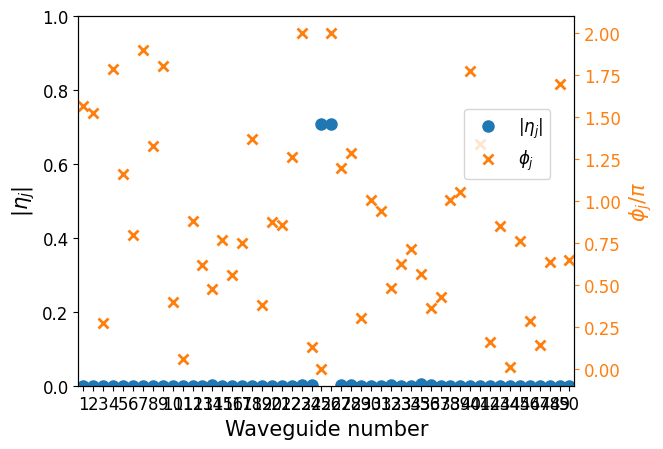

In [ ]:
# Plot of pump profile
fig, ax = plt.subplots()
ax.plot(amp, 'o', ms=8, label='$|\\eta_j|$')
ax2 = plt.twinx()
ax2.plot(np.array(phase) / np.pi, 'xC1', ms=7, mew=2, label='$\\phi_j$')

#ax2.set_yticks(np.linspace(0, 2*np.pi, 9), [f'$\\frac{{{i}}}{{{j}}}\\,\\pi$' if j != 1 else f'${i}\\,\\pi$' if j==1 and i > 1 else '$\\pi$' if j == 1 and i == 1 else '$0$' for i,j in [k.as_integer_ratio() for k in np.linspace(0, 2*np.pi, 9)/np.pi]])
xticks = np.linspace(1, N, N, dtype='int')
ax.set_xticks(xticks - 1, xticks, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', colors='C1', labelsize=12)
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=False)
ax.set_xlim(-0.5, N - 0.5)
ax.set_ylim(0, 1)
ax.set_ylabel('$|\\eta_j|$', fontsize=15)
ax2.set_ylabel('$\\phi_j / \\pi$', fontsize=15, color='C1')
ax.set_xlabel('Waveguide number', fontsize=15)
fig.legend(fontsize=12, loc=(0.7,0.6))

plt.show()

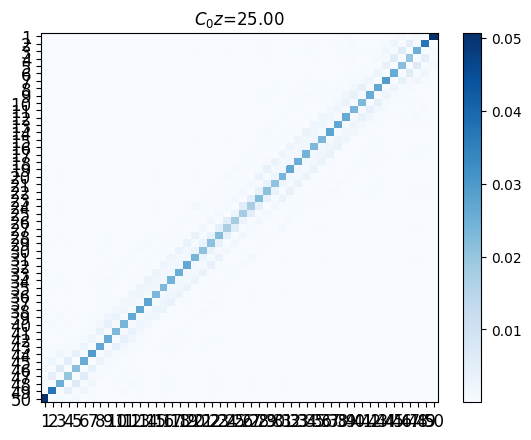

In [ ]:
# Plot of optimized matrix
fig, ax = plt.subplots()
plt.pcolor(corr_m, cmap='Blues')

xticks = np.arange(0.5, N, 1)
xlabels = np.arange(1, N + 1, 1)
plt.xticks(xticks, xlabels, fontsize=12)
plt.yticks(xticks, xlabels, fontsize=12)
plt.title(f'$C_0z$={z:.2f}')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

# Hadamard product examples

## Center pump (homogeneous coupling profile, $N=7$)

In [ ]:
# User-defined parameters
N = 7
C0, g, alpha = 1
z1 = 1 / C0         # Position 1
z2 = 20 / C0        # Position 2

pump_data = eta(N, profile_type='one')
transf_data = transform(N)

# Obtains matrices at z = z1
Q_s1, T_s1, P_s = Q_s(z1, C0, g, alpha, pump_data, transf_data, add_matrices=True)
K_s1 = JSA(Q_s1)
K_i1 = JSA(s2i(Q_s1, transf_data))

# Obtains matrices at z = z1
Q_s2, T_s2, _ = Q_s(z2, C0, g, alpha, pump_data, transf_data, add_matrices=True)
K_s2 = JSA(Q_s2)
K_i2 = JSA(s2i(Q_s2, transf_data))

# Define tolerance
tol = 1e-10

# Make zero entries with magnitude below given tolerance
P_s[np.abs(P_s) < tol] = 0
K_s1[np.abs(K_s1) < tol] = 0
T_s1[np.abs(T_s1) < tol] = 0
K_i1[np.abs(K_i1) < tol] = 0
K_s2[np.abs(K_s2) < tol] = 0
T_s2[np.abs(T_s2) < tol] = 0
K_i2[np.abs(K_i2) < tol] = 0

Figure 2

[]

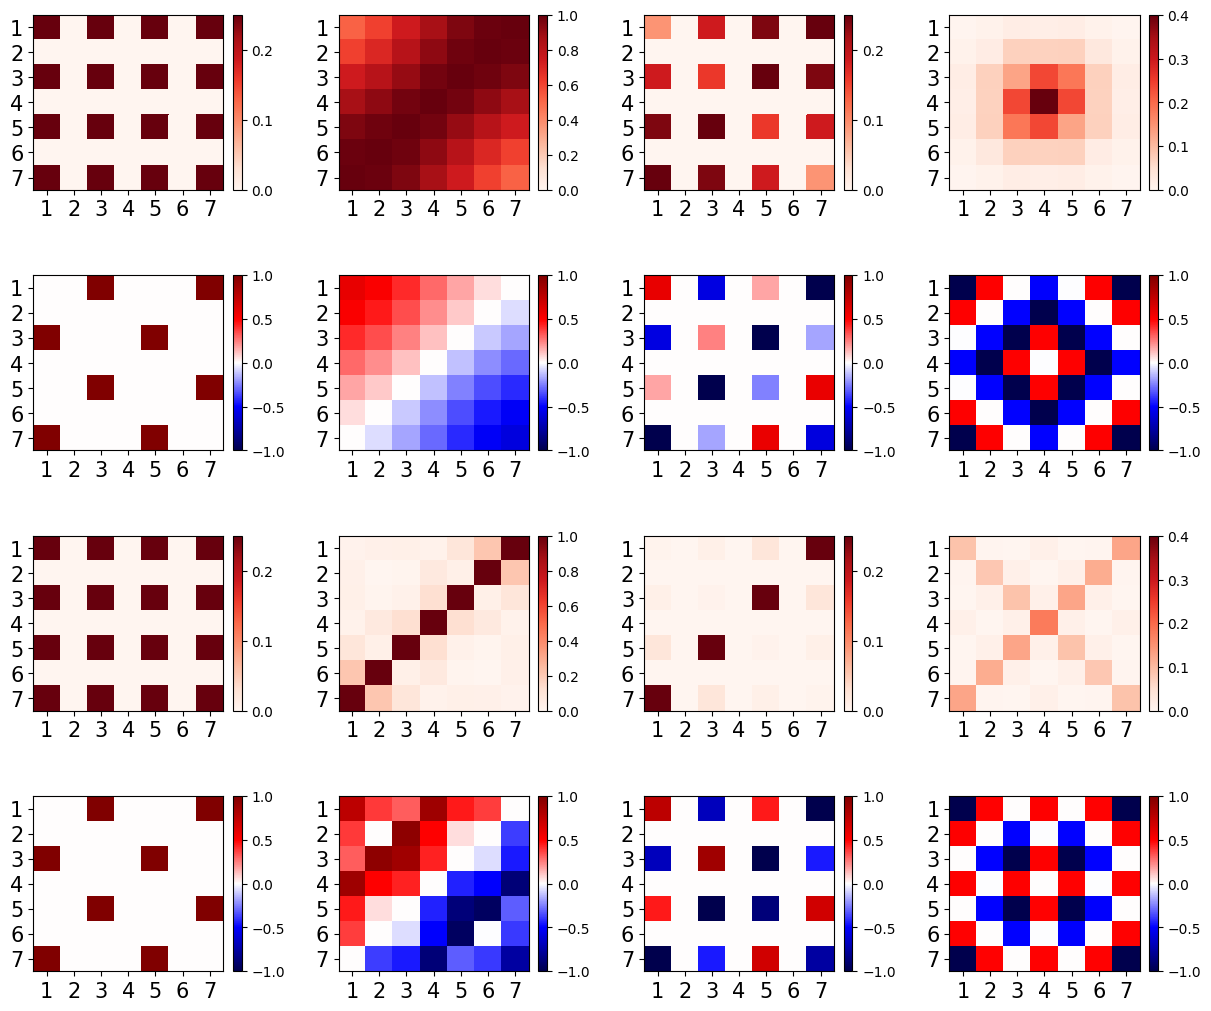

In [ ]:
labels = np.array([i for i in range(1, N + 1)])

fig = plt.figure(figsize=(12, 10), layout="constrained")
spec = fig.add_gridspec(4, 4, wspace=0.1, hspace=0.2)

ax00 = fig.add_subplot(spec[0, 0])
ax00.invert_yaxis()
p00 = ax00.pcolor(np.abs(P_s), cmap='Reds')
ax00.set_xticks(labels - 0.5, labels, fontsize=15)
ax00.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p00)

ax10 = fig.add_subplot(spec[1, 0])
ax10.invert_yaxis()
p10 = ax10.pcolor(np.angle(P_s) / np.pi, cmap='seismic', vmin=-1)
ax10.set_xticks(labels - 0.5, labels, fontsize=15)
ax10.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p10)

ax01 = fig.add_subplot(spec[0, 1])
ax01.invert_yaxis()
p01 = ax01.pcolor(np.abs(T_s1), cmap='Reds', vmin=0)
ax01.set_xticks(labels - 0.5, labels, fontsize=15)
ax01.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p01)

ax02 = fig.add_subplot(spec[0, 2])
ax02.invert_yaxis()
p02 = ax02.pcolor(np.abs(K_s1 / (2j * z1 * g * alpha)), cmap='Reds')
ax02.set_xticks(labels - 0.5, labels, fontsize=15)
ax02.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p02)

ax03 = fig.add_subplot(spec[0, 3])
ax03.invert_yaxis()
_ = np.abs(K_i1 / (2j * z1 * g * alpha))
p03 = ax03.pcolor(_, cmap='Reds', vmin=0, vmax=_.max())
ax03.set_xticks(labels - 0.5, labels, fontsize=15)
ax03.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p03)

ax11 = fig.add_subplot(spec[1, 1])
ax11.invert_yaxis()
p11 = ax11.pcolor(np.angle(T_s1) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax11.set_xticks(labels - 0.5, labels, fontsize=15)
ax11.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p11)

ax12 = fig.add_subplot(spec[1, 2])
ax12.invert_yaxis()
p12 = ax12.pcolor(np.angle(K_s1 / (2j * z1 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax12.set_xticks(labels - 0.5, labels, fontsize=15)
ax12.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p12)

ax13 = fig.add_subplot(spec[1, 3])
ax13.invert_yaxis()
p13 = ax13.pcolor(np.angle(K_i1 / (2j * z1 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax13.set_xticks(labels - 0.5, labels, fontsize=15)
ax13.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p13)

########################

ax20 = fig.add_subplot(spec[2, 0])
ax20.invert_yaxis()
p20 = ax20.pcolor(np.abs(P_s), cmap='Reds')
ax20.set_xticks(labels - 0.5, labels, fontsize=15)
ax20.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p20)

ax30 = fig.add_subplot(spec[3, 0])
ax30.invert_yaxis()
p30 = ax30.pcolor(np.angle(P_s) / np.pi, cmap='seismic', vmin=-1)
ax30.set_xticks(labels - 0.5, labels, fontsize=15)
ax30.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p30)

ax21 = fig.add_subplot(spec[2, 1])
ax21.invert_yaxis()
p21 = ax21.pcolor(np.abs(T_s2), cmap='Reds', vmin=0)
ax21.set_xticks(labels - 0.5, labels, fontsize=15)
ax21.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p21)

ax22 = fig.add_subplot(spec[2, 2])
ax22.invert_yaxis()
p22 = ax22.pcolor(np.abs(K_s2 / (2j * z2 * g * alpha)), cmap='Reds')
ax22.set_xticks(labels - 0.5, labels, fontsize=15)
ax22.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p22)

ax23 = fig.add_subplot(spec[2, 3])
ax23.invert_yaxis()
p23 = ax23.pcolor(np.abs(K_i2 / (2j * z2 * g * alpha)), cmap='Reds', vmin=0, vmax=_.max())
ax23.set_xticks(labels - 0.5, labels, fontsize=15)
ax23.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p23)

ax31 = fig.add_subplot(spec[3, 1])
ax31.invert_yaxis()
p31 = ax31.pcolor(np.angle(T_s2) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax31.set_xticks(labels - 0.5, labels, fontsize=15)
ax31.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p31)

ax32 = fig.add_subplot(spec[3, 2])
ax32.invert_yaxis()
p32 = ax32.pcolor(np.angle(K_s2 / (2j * z2 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax32.set_xticks(labels - 0.5, labels, fontsize=15)
ax32.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p32)

ax33 = fig.add_subplot(spec[3, 3])
ax33.invert_yaxis()
p33 = ax33.pcolor(np.angle(K_i2 / (2j * z2 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax33.set_xticks(labels - 0.5, labels, fontsize=15)
ax33.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p33)

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.plot()

## Flat pump (homogeneous coupling profile, $N=7$)

In [ ]:
# Define parameters
N = 7
C0 = 1
g = 1
alpha = 1
z1 = 1 / C0
z2 = 20 / C0

pump_data = eta(N)
transf_data = transform(N)

# Obtains matrices at z = z1
Q_s1, T_s1, P_s = Q_s(z1, C0, g, alpha, pump_data, transf_data, add_matrices=True)
K_s1 = JSA(Q_s1)
K_i1 = JSA(s2i(Q_s1, transf_data))
P_i = s2i(P_s, transf_data)

# Obtains matrices at z = z1
Q_s2, T_s2, _ = Q_s(z2, C0, g, alpha, pump_data, transf_data, add_matrices=True)
K_s2 = JSA(Q_s2)
K_i2 = JSA(s2i(Q_s2, transf_data))

# Define tolerance
tol = 1e-10

# Make zero entries with magnitude below given tolerance
P_i[np.abs(P_i) < tol] = 0
P_s[np.abs(P_s) < tol] = 0
K_s1[np.abs(K_s1) < tol] = 0
T_s1[np.abs(T_s1) < tol] = 0
K_i1[np.abs(K_i1) < tol] = 0
K_s2[np.abs(K_s2) < tol] = 0
T_s2[np.abs(T_s2) < tol] = 0
K_i2[np.abs(K_i2) < tol] = 0

Figure 1S

[]

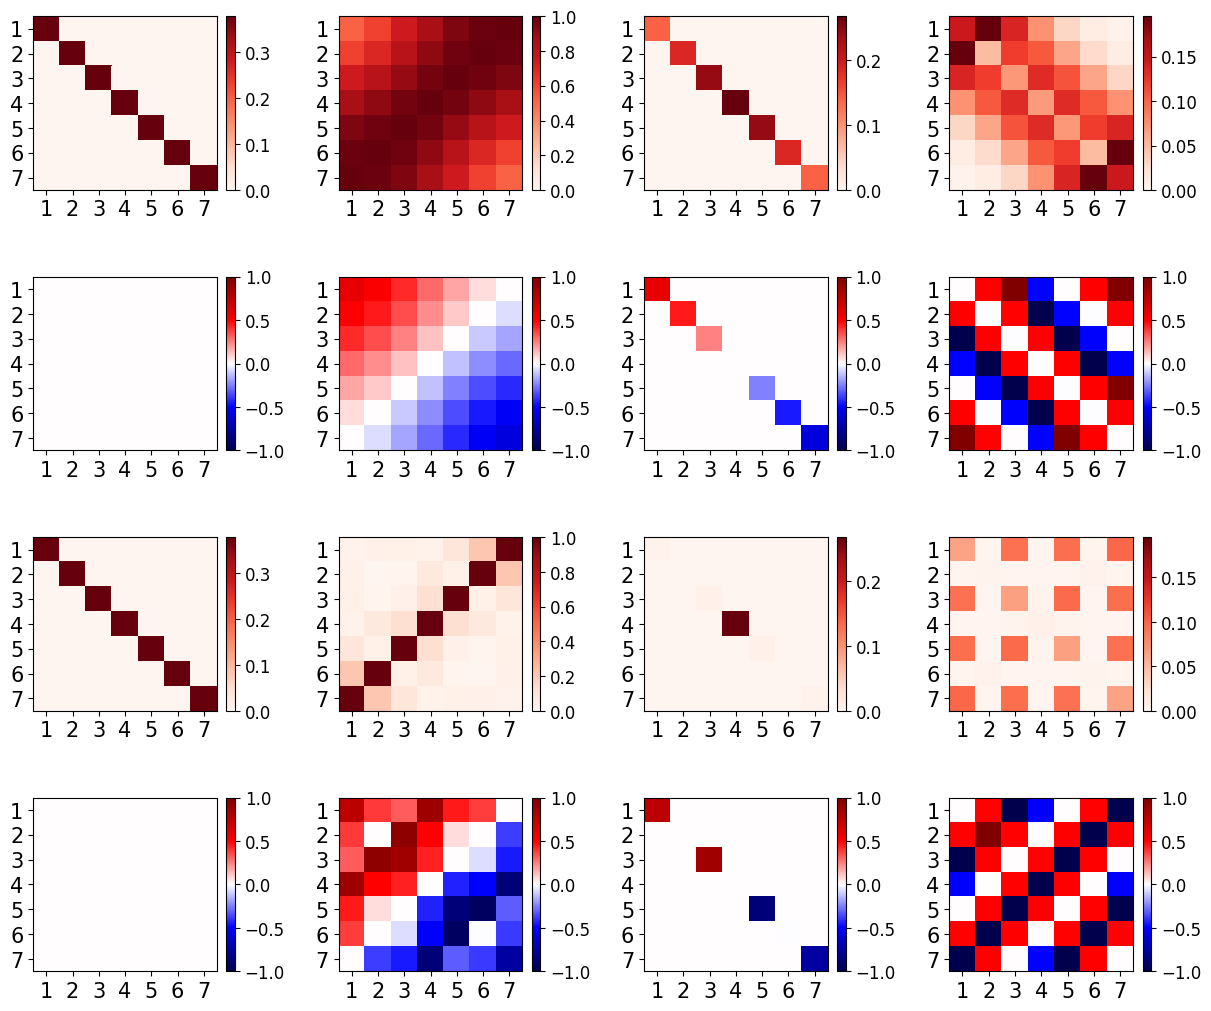

In [ ]:
labels = np.array([i for i in range(1, N + 1)])

fig = plt.figure(figsize=(12, 10), layout="constrained")
spec = fig.add_gridspec(4, 4, wspace=0.1, hspace=0.2)

ax00 = fig.add_subplot(spec[0, 0])
ax00.invert_yaxis()
p00 = ax00.pcolor(np.abs(P_i), cmap='Reds')
ax00.set_xticks(labels - 0.5, labels, fontsize=15)
ax00.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p00)

ax10 = fig.add_subplot(spec[1, 0])
ax10.invert_yaxis()
p10 = ax10.pcolor(np.angle(P_i) / np.pi, cmap='seismic', vmin=-1, vmax=1)
ax10.set_xticks(labels - 0.5, labels, fontsize=15)
ax10.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p10)

ax01 = fig.add_subplot(spec[0, 1])
ax01.invert_yaxis()
p01 = ax01.pcolor(np.abs(T_s1), cmap='Reds', vmin=0)
ax01.set_xticks(labels - 0.5, labels, fontsize=15)
ax01.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p01)

ax02 = fig.add_subplot(spec[0, 2])
ax02.invert_yaxis()
p02 = ax02.pcolor(np.abs(K_s1 / (2j * z1 * g * alpha)), cmap='Reds')
ax02.set_xticks(labels - 0.5, labels, fontsize=15)
ax02.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p02)

ax03 = fig.add_subplot(spec[0, 3])
ax03.invert_yaxis()
_ = np.abs(K_i1 / (2j * z1 * g * alpha))
p03 = ax03.pcolor(_, cmap='Reds', vmin=0, vmax=_.max())
ax03.set_xticks(labels - 0.5, labels, fontsize=15)
ax03.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p03)

ax11 = fig.add_subplot(spec[1, 1])
ax11.invert_yaxis()
p11 = ax11.pcolor(np.angle(T_s1) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax11.set_xticks(labels - 0.5, labels, fontsize=15)
ax11.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p11)

ax12 = fig.add_subplot(spec[1, 2])
ax12.invert_yaxis()
p12 = ax12.pcolor(np.angle(K_s1 / (2j * z1 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax12.set_xticks(labels - 0.5, labels, fontsize=15)
ax12.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p12)

ax13 = fig.add_subplot(spec[1, 3])
ax13.invert_yaxis()
p13 = ax13.pcolor(np.angle(K_i1 / (2j * z1 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax13.set_xticks(labels - 0.5, labels, fontsize=15)
ax13.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p13)

########################

ax20 = fig.add_subplot(spec[2, 0])
ax20.invert_yaxis()
p20 = ax20.pcolor(np.abs(P_s), cmap='Reds')
ax20.set_xticks(labels - 0.5, labels, fontsize=15)
ax20.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p20)

ax30 = fig.add_subplot(spec[3, 0])
ax30.invert_yaxis()
p30 = ax30.pcolor(np.angle(P_s) / np.pi, cmap='seismic', vmin=-1, vmax=1)
ax30.set_xticks(labels - 0.5, labels, fontsize=15)
ax30.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p30)

ax21 = fig.add_subplot(spec[2, 1])
ax21.invert_yaxis()
p21 = ax21.pcolor(np.abs(T_s2), cmap='Reds', vmin=0)
ax21.set_xticks(labels - 0.5, labels, fontsize=15)
ax21.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p21)

ax22 = fig.add_subplot(spec[2, 2])
ax22.invert_yaxis()
p22 = ax22.pcolor(np.abs(K_s2 / (2j * z2 * g * alpha)), cmap='Reds')
ax22.set_xticks(labels - 0.5, labels, fontsize=15)
ax22.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p22)

ax23 = fig.add_subplot(spec[2, 3])
ax23.invert_yaxis()
p23 = ax23.pcolor(np.abs(K_i2 / (2j * z2 * g * alpha)), cmap='Reds', vmin=0, vmax=_.max())
ax23.set_xticks(labels - 0.5, labels, fontsize=15)
ax23.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p23)

ax31 = fig.add_subplot(spec[3, 1])
ax31.invert_yaxis()
p31 = ax31.pcolor(np.angle(T_s2) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax31.set_xticks(labels - 0.5, labels, fontsize=15)
ax31.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p31)

ax32 = fig.add_subplot(spec[3, 2])
ax32.invert_yaxis()
p32 = ax32.pcolor(np.angle(K_s2 / (2j * z2 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax32.set_xticks(labels - 0.5, labels, fontsize=15)
ax32.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p32)

ax33 = fig.add_subplot(spec[3, 3])
ax33.invert_yaxis()
p33 = ax33.pcolor(np.angle(K_i2 / (2j * z2 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax33.set_xticks(labels - 0.5, labels, fontsize=15)
ax33.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p33)

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.plot()

## Flat pump amplitude with alternating $\pi$ phase (homogeneous coupling profile, $N=7$)

In [ ]:
# Define parameters
N = 7
C0 = 1
g = 1
alpha = 1
z1 = 1 / C0
z2 = 20 / C0

pump = [1 if i % 2 == 0 else -1 for i in range(N)]
pump_data = eta(pump=pump, default=False)
transf_data = transform(N)

# Obtains matrices at z = z1
Q_s1, T_s1, P_s = Q_s(z1, C0, g, alpha, pump_data, transf_data, add_matrices=True)
K_s1 = JSA(Q_s1)
K_i1 = JSA(s2i(Q_s1, transf_data))
P_i = s2i(P_s, transf_data)

# Obtains matrices at z = z1
Q_s2, T_s2, _ = Q_s(z2, C0, g, alpha, pump_data, transf_data, add_matrices=True)
K_s2 = JSA(Q_s2)
K_i2 = JSA(s2i(Q_s2, transf_data))

# Define tolerance
tol = 1e-10

# Make zero entries with magnitude below given tolerance
P_i[np.abs(P_i) < tol] = 0
P_s[np.abs(P_s) < tol] = 0
K_s1[np.abs(K_s1) < tol] = 0
T_s1[np.abs(T_s1) < tol] = 0
K_i1[np.abs(K_i1) < tol] = 0
K_s2[np.abs(K_s2) < tol] = 0
T_s2[np.abs(T_s2) < tol] = 0
K_i2[np.abs(K_i2) < tol] = 0

Figure 2S

[]

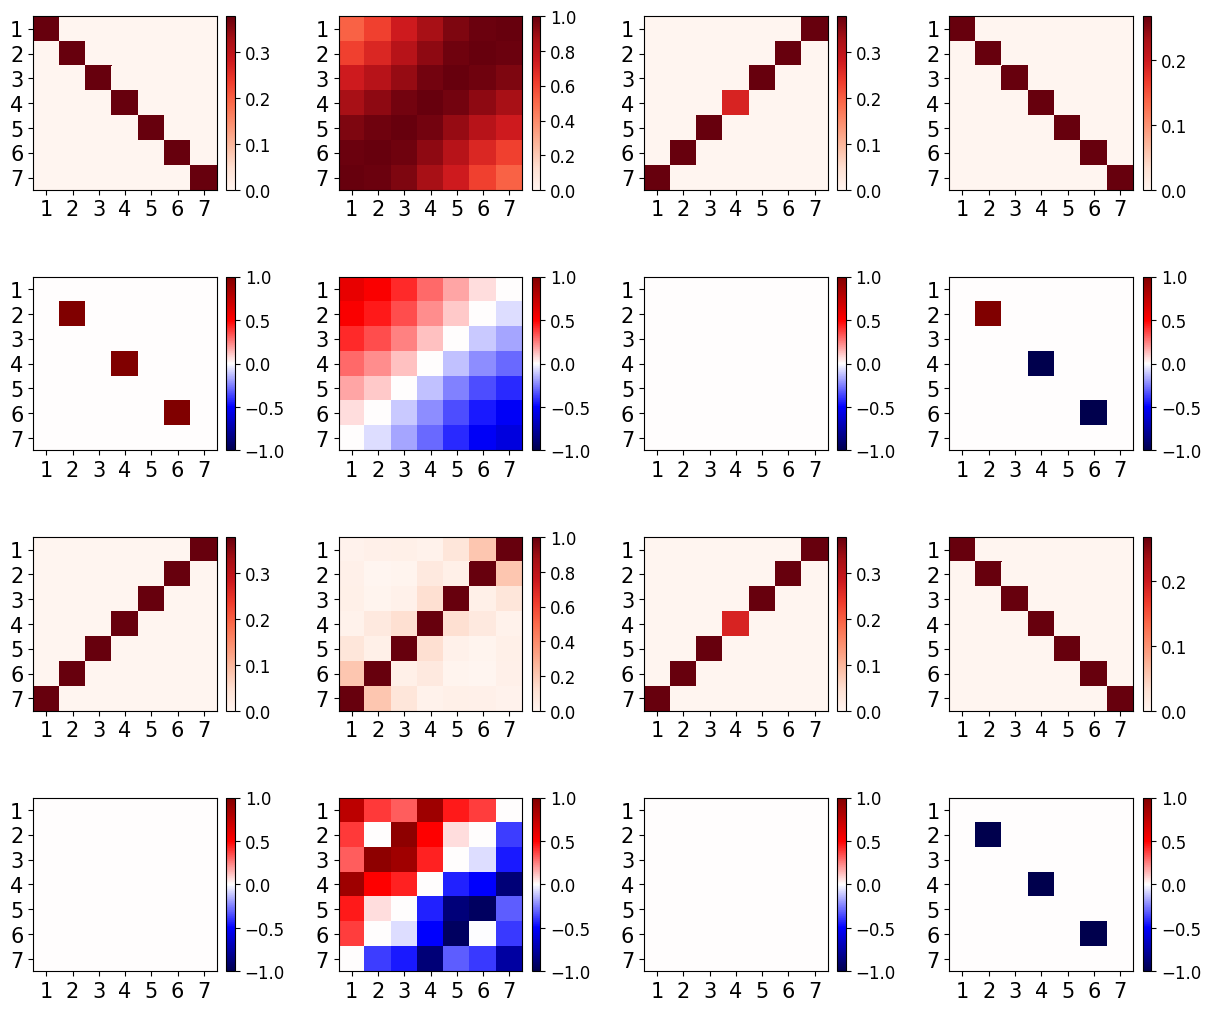

In [ ]:
labels = np.array([i for i in range(1, N + 1)])

fig = plt.figure(figsize=(12, 10), layout="constrained")
spec = fig.add_gridspec(4, 4, wspace=0.1, hspace=0.2)

ax00 = fig.add_subplot(spec[0, 0])
ax00.invert_yaxis()
p00 = ax00.pcolor(np.abs(P_i), cmap='Reds')
ax00.set_xticks(labels - 0.5, labels, fontsize=15)
ax00.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p00)

ax10 = fig.add_subplot(spec[1, 0])
ax10.invert_yaxis()
p10 = ax10.pcolor(np.angle(P_i) / np.pi, cmap='seismic', vmin=-1, vmax=1)
ax10.set_xticks(labels - 0.5, labels, fontsize=15)
ax10.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p10)

ax01 = fig.add_subplot(spec[0, 1])
ax01.invert_yaxis()
p01 = ax01.pcolor(np.abs(T_s1), cmap='Reds', vmin=0)
ax01.set_xticks(labels - 0.5, labels, fontsize=15)
ax01.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p01)

ax02 = fig.add_subplot(spec[0, 2])
ax02.invert_yaxis()
p02 = ax02.pcolor(np.abs(K_s1 / (2j * z1 * g * alpha)), cmap='Reds')
ax02.set_xticks(labels - 0.5, labels, fontsize=15)
ax02.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p02)

ax03 = fig.add_subplot(spec[0, 3])
ax03.invert_yaxis()
_ = np.abs(K_i1 / (2j * z1 * g * alpha))
p03 = ax03.pcolor(_, cmap='Reds', vmin=0, vmax=_.max())
ax03.set_xticks(labels - 0.5, labels, fontsize=15)
ax03.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p03)

ax11 = fig.add_subplot(spec[1, 1])
ax11.invert_yaxis()
p11 = ax11.pcolor(np.angle(T_s1) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax11.set_xticks(labels - 0.5, labels, fontsize=15)
ax11.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p11)

ax12 = fig.add_subplot(spec[1, 2])
ax12.invert_yaxis()
p12 = ax12.pcolor(np.angle(K_s1 / (2j * z1 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax12.set_xticks(labels - 0.5, labels, fontsize=15)
ax12.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p12)

ax13 = fig.add_subplot(spec[1, 3])
ax13.invert_yaxis()
p13 = ax13.pcolor(np.angle(K_i1 / (2j * z1 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax13.set_xticks(labels - 0.5, labels, fontsize=15)
ax13.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p13)

########################

ax20 = fig.add_subplot(spec[2, 0])
ax20.invert_yaxis()
p20 = ax20.pcolor(np.abs(P_s), cmap='Reds')
ax20.set_xticks(labels - 0.5, labels, fontsize=15)
ax20.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p20)

ax30 = fig.add_subplot(spec[3, 0])
ax30.invert_yaxis()
p30 = ax30.pcolor(np.angle(P_s) / np.pi, cmap='seismic', vmin=-1, vmax=1)
ax30.set_xticks(labels - 0.5, labels, fontsize=15)
ax30.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p30)

ax21 = fig.add_subplot(spec[2, 1])
ax21.invert_yaxis()
p21 = ax21.pcolor(np.abs(T_s2), cmap='Reds', vmin=0)
ax21.set_xticks(labels - 0.5, labels, fontsize=15)
ax21.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p21)

ax22 = fig.add_subplot(spec[2, 2])
ax22.invert_yaxis()
p22 = ax22.pcolor(np.abs(K_s2 / (2j * z2 * g * alpha)), cmap='Reds')
ax22.set_xticks(labels - 0.5, labels, fontsize=15)
ax22.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p22)

ax23 = fig.add_subplot(spec[2, 3])
ax23.invert_yaxis()
p23 = ax23.pcolor(np.abs(K_i2 / (2j * z2 * g * alpha)), cmap='Reds', vmin=0, vmax=_.max())
ax23.set_xticks(labels - 0.5, labels, fontsize=15)
ax23.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p23)

ax31 = fig.add_subplot(spec[3, 1])
ax31.invert_yaxis()
p31 = ax31.pcolor(np.angle(T_s2) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax31.set_xticks(labels - 0.5, labels, fontsize=15)
ax31.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p31)

ax32 = fig.add_subplot(spec[3, 2])
ax32.invert_yaxis()
p32 = ax32.pcolor(np.angle(K_s2 / (2j * z2 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax32.set_xticks(labels - 0.5, labels, fontsize=15)
ax32.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p32)

ax33 = fig.add_subplot(spec[3, 3])
ax33.invert_yaxis()
p33 = ax33.pcolor(np.angle(K_i2 / (2j * z2 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax33.set_xticks(labels - 0.5, labels, fontsize=15)
ax33.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p33)

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.plot()

## Two consecutive waveguides in the middle of the array injected with the same amplitude and phase (parabolic coupling profile, $N=8$)

In [ ]:
# Define parameters
N = 8
C0 = 1
g = 1
alpha = 1
z1 = 1 / C0
z2 = 20 / C0

pump = [1 if (i == N / 2 - 1) or (i == N / 2) else 0 for i in range(N)]
pump_data = eta(pump=pump, default=False)
f = [np.sqrt((i + 1) * (N - 1 - i)) / 2  for i in range(N - 1)] # parabolic coupling profile
transf_data = transform(f=f, default=False)

# Obtains matrices at z = z1
Q_s1, T_s1, P_s = Q_s(z1, C0, g, alpha, pump_data, transf_data, add_matrices=True)
K_s1 = JSA(Q_s1)
K_i1 = JSA(s2i(Q_s1, transf_data))
P_i = s2i(P_s, transf_data)

# Obtains matrices at z = z1
Q_s2, T_s2, _ = Q_s(z2, C0, g, alpha, pump_data, transf_data, add_matrices=True)
K_s2 = JSA(Q_s2)
K_i2 = JSA(s2i(Q_s2, transf_data))

# Define tolerance
tol = 1e-10

# Make zero entries with magnitude below given tolerance
P_i[np.abs(P_i) < tol] = 0
P_s[np.abs(P_s) < tol] = 0
K_s1[np.abs(K_s1) < tol] = 0
T_s1[np.abs(T_s1) < tol] = 0
K_i1[np.abs(K_i1) < tol] = 0
K_s2[np.abs(K_s2) < tol] = 0
T_s2[np.abs(T_s2) < tol] = 0
K_i2[np.abs(K_i2) < tol] = 0

Figure 3S

[]

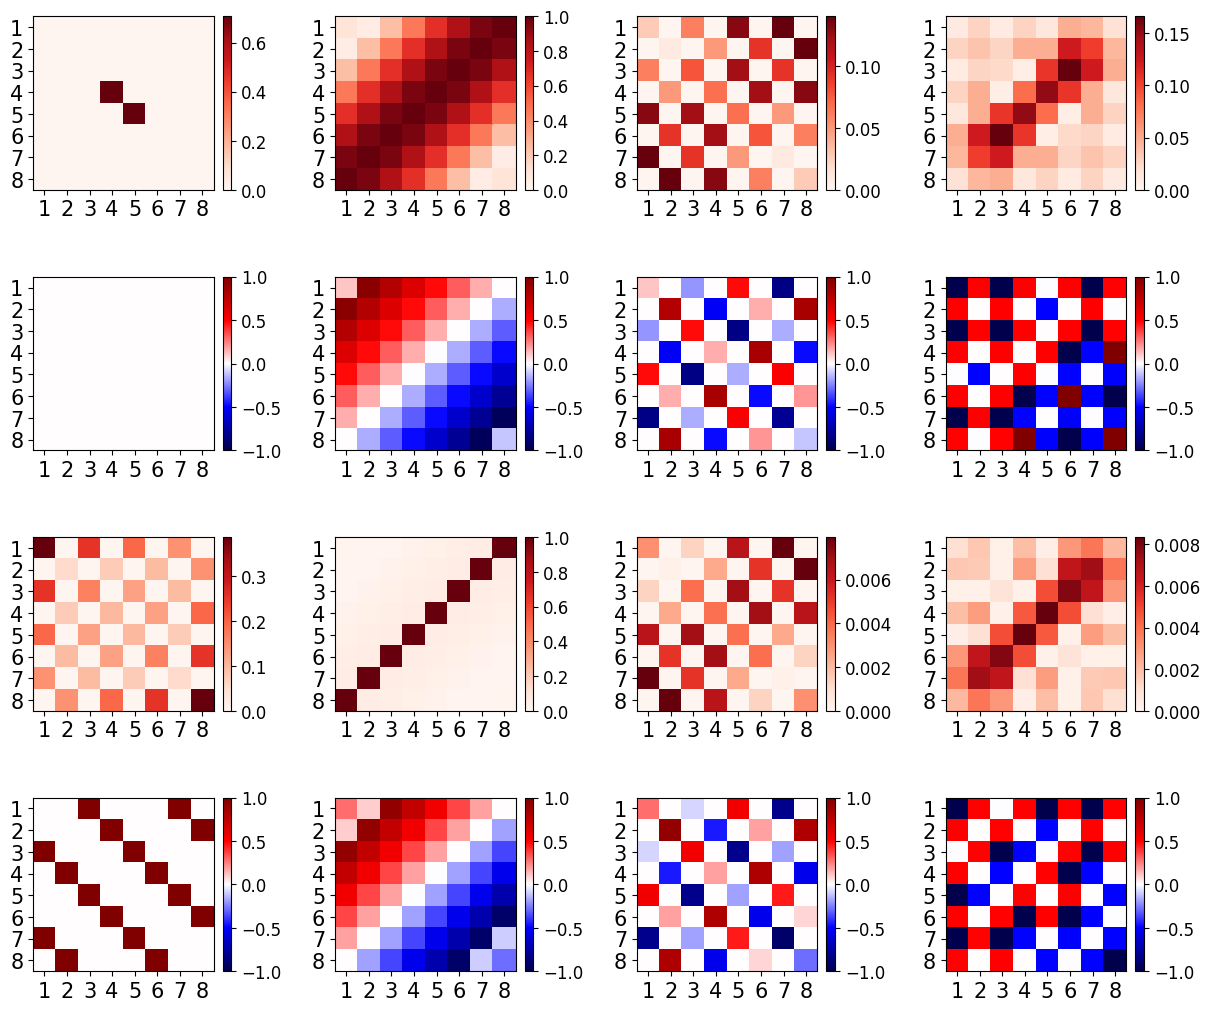

In [ ]:
labels = np.array([i for i in range(1, N + 1)])

fig = plt.figure(figsize=(12, 10), layout="constrained")
spec = fig.add_gridspec(4, 4, wspace=0.1, hspace=0.2)

ax00 = fig.add_subplot(spec[0, 0])
ax00.invert_yaxis()
p00 = ax00.pcolor(np.abs(P_i), cmap='Reds')
ax00.set_xticks(labels - 0.5, labels, fontsize=15)
ax00.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p00)

ax10 = fig.add_subplot(spec[1, 0])
ax10.invert_yaxis()
p10 = ax10.pcolor(np.angle(P_i) / np.pi, cmap='seismic', vmin=-1, vmax=1)
ax10.set_xticks(labels - 0.5, labels, fontsize=15)
ax10.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p10)

ax01 = fig.add_subplot(spec[0, 1])
ax01.invert_yaxis()
p01 = ax01.pcolor(np.abs(T_s1), cmap='Reds', vmin=0)
ax01.set_xticks(labels - 0.5, labels, fontsize=15)
ax01.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p01)

ax02 = fig.add_subplot(spec[0, 2])
ax02.invert_yaxis()
p02 = ax02.pcolor(np.abs(K_s1 / (2j * z1 * g * alpha)), cmap='Reds')
ax02.set_xticks(labels - 0.5, labels, fontsize=15)
ax02.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p02)

ax03 = fig.add_subplot(spec[0, 3])
ax03.invert_yaxis()
_ = np.abs(K_i1 / (2j * z1 * g * alpha))
p03 = ax03.pcolor(_, cmap='Reds', vmin=0, vmax=_.max())
ax03.set_xticks(labels - 0.5, labels, fontsize=15)
ax03.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p03)

ax11 = fig.add_subplot(spec[1, 1])
ax11.invert_yaxis()
p11 = ax11.pcolor(np.angle(T_s1) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax11.set_xticks(labels - 0.5, labels, fontsize=15)
ax11.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p11)

ax12 = fig.add_subplot(spec[1, 2])
ax12.invert_yaxis()
p12 = ax12.pcolor(np.angle(K_s1 / (2j * z1 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax12.set_xticks(labels - 0.5, labels, fontsize=15)
ax12.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p12)

ax13 = fig.add_subplot(spec[1, 3])
ax13.invert_yaxis()
p13 = ax13.pcolor(np.angle(K_i1 / (2j * z1 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax13.set_xticks(labels - 0.5, labels, fontsize=15)
ax13.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p13)

########################

ax20 = fig.add_subplot(spec[2, 0])
ax20.invert_yaxis()
p20 = ax20.pcolor(np.abs(P_s), cmap='Reds')
ax20.set_xticks(labels - 0.5, labels, fontsize=15)
ax20.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p20)

ax30 = fig.add_subplot(spec[3, 0])
ax30.invert_yaxis()
p30 = ax30.pcolor(np.angle(P_s) / np.pi, cmap='seismic', vmin=-1, vmax=1)
ax30.set_xticks(labels - 0.5, labels, fontsize=15)
ax30.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p30)

ax21 = fig.add_subplot(spec[2, 1])
ax21.invert_yaxis()
p21 = ax21.pcolor(np.abs(T_s2), cmap='Reds', vmin=0)
ax21.set_xticks(labels - 0.5, labels, fontsize=15)
ax21.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p21)

ax22 = fig.add_subplot(spec[2, 2])
ax22.invert_yaxis()
p22 = ax22.pcolor(np.abs(K_s2 / (2j * z2 * g * alpha)), cmap='Reds')
ax22.set_xticks(labels - 0.5, labels, fontsize=15)
ax22.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p22)

ax23 = fig.add_subplot(spec[2, 3])
ax23.invert_yaxis()
p23 = ax23.pcolor(np.abs(K_i2 / (2j * z2 * g * alpha)), cmap='Reds', vmin=0)
ax23.set_xticks(labels - 0.5, labels, fontsize=15)
ax23.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p23)

ax31 = fig.add_subplot(spec[3, 1])
ax31.invert_yaxis()
p31 = ax31.pcolor(np.angle(T_s2) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax31.set_xticks(labels - 0.5, labels, fontsize=15)
ax31.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p31)

ax32 = fig.add_subplot(spec[3, 2])
ax32.invert_yaxis()
p32 = ax32.pcolor(np.angle(K_s2 / (2j * z2 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax32.set_xticks(labels - 0.5, labels, fontsize=15)
ax32.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p32)

ax33 = fig.add_subplot(spec[3, 3])
ax33.invert_yaxis()
p33 = ax33.pcolor(np.angle(K_i2 / (2j * z2 * g * alpha)) / np.pi, cmap='seismic', vmax=1, vmin=-1)
ax33.set_xticks(labels - 0.5, labels, fontsize=15)
ax33.set_yticks(labels - 0.5, labels, fontsize=15)
fig.colorbar(p33)

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.plot()

# Optimization examples

## Coupling profiles with analytic eigenvalues and eigenvectors

Figure 4S

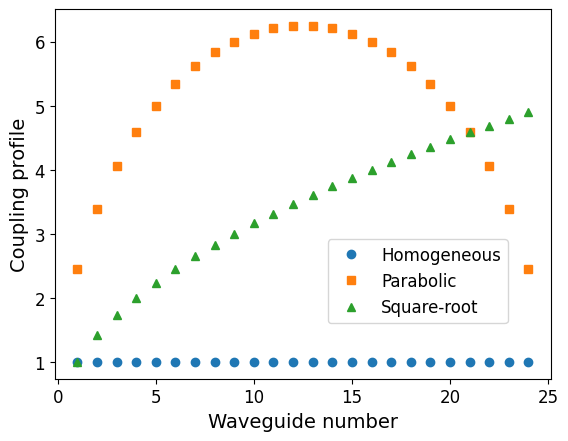

In [ ]:
# Plot of coupling profiles with analytic eigenvalues and eigenvectors
N = 25
f1 = [1 for i in range(N - 1)]                                    # homogeneous coupling profile
f2 = [np.sqrt((i + 1) * (N - 1 - i)) / 2  for i in range(N - 1)]  # parabolic coupling profile
f3 = [np.sqrt(i + 1) for i in range(N - 1)]                       # square-root coupling profile
waveguide_number = [i + 1 for i in range(N - 1)]

plt.plot(waveguide_number, f1, 'o')
plt.plot(waveguide_number, f2, 's')
plt.plot(waveguide_number, f3, '^')

plt.ylabel('Coupling profile', fontsize=14)
plt.xlabel('Waveguide number', fontsize=14)
plt.legend(['Homogeneous', 'Parabolic', 'Square-root'], loc=(0.55, 0.15), fontsize=12)

plt.show()

## Antidiagonal correlation matrix with equal nonvanishing entries ($N=50$)

In [ ]:
# Pump profiles and z positions obtained after optimization

# For homogeneous coupling profile:
z_homo = 25.0
pump_amp_homo = np.array([0.0, 0.0, 0.0, 0.0, 0.00023059845930500957, 0.0, 0.0, 0.0, 0.003499563983112165, 0.0019253455396566763, 0.007890540524069503, 0.0, 0.00041681241563403995, 0.0, 0.0023365078243730067, 0.0054742627103660756, 0.0, 0.0, 0.00044943831694910734, 0.011594681661267215, 0.002536299396595354, 0.015090328558295821, 0.03636096786158948, 0.029527750181470042, 0.7037864137851636, 0.7067606940088863, 0.0397383611604847, 0.0, 0.0275253439574521, 0.0, 0.0, 0.005080943298598544, 0.0015374785295607246, 0.004892079560627926, 0.00785282433911374, 0.0, 0.0, 0.0, 0.0, 0.004976412924184169, 0.0009619816430151735, 0.00418405740178996, 0.0005822244102064478, 0.0003993086751548576, 2.1001636705103908e-05, 0.0017329053829071238, 0.0, 0.000283089007568753, 0.0, 0.0])
pump_pha_homo = np.array([3.3128816524678473, 1.2623931820369139, 0.5454478008432174, 2.6989682680103058, 1.793509217570421, 5.029753400291872, 2.223613882486881, 3.43101605775266, 3.7996896846789436, 5.241261349382115, 6.283185307179586, 1.3072005975068808, 4.071087787292232, 4.190720374841408, 1.5932424626984765, 2.259691680202696, 1.9809394761450323, 0.9982631379051269, 4.703617924902626, 6.081161780379487, 4.237282194602059, 3.4587812343729976, 6.283185307179586, 3.1596401292216316, 0.04754859742785663, 0.047181821221205934, 3.2191308932280576, 2.241936660382689, 3.0924232366134006, 5.81584342279609, 2.0981085246757107, 3.1362394718497955, 1.6805743777755446, 1.3590230714115812, 2.61322368458895, 5.1704707510005505, 3.279711151755775, 6.179818547610899, 0.23324954698140116, 0.897289406922392, 3.590138465848471, 3.3411009823434497, 2.2828519424239553, 1.5635088655880116, 4.825704494286186, 5.1924654292020715, 1.6801357505632901, 1.7686267790371357, 0.7526184471243821, 1.711477772193303])

# For parabolic coupling profile:
z_para = 9.42596789782814
pump_amp_para = np.array([0.00021775738654403683, 0.0, 0.0005673462655127032, 2.8179329731591338e-05, 9.306168702341112e-06, 0.00012686123191477032, 0.0, 0.0, 0.0, 0.00022728386704952687, 0.0, 0.0, 0.0, 0.0010768411666332138, 0.0004080922208708217, 0.00031007421679131404, 0.00015017464414790964, 0.00012491132914755208, 0.00011152885858855799, 7.462266637827487e-06, 0.0, 0.0003452467855223461, 0.0006667907432326745, 0.0006506857452518536, 0.7071992563616827, 0.7069943640692529, 0.000790140771342847, 0.0010727624914614092, 0.0005184523017405507, 7.561087649693925e-05, 3.139129091186684e-05, 0.0027151264999650255, 0.0, 0.00040831319863011777, 0.0038311617229807907, 0.0006943266757119336, 0.000466374464435472, 2.8541509485282803e-05, 7.94317342276621e-05, 1.334842657313192e-05, 0.0, 3.253315397557375e-05, 0.0, 0.0, 0.0, 0.0, 1.4225723177088156e-05, 0.0005536977320570778, 3.34180889802021e-05, 0.0])
pump_pha_para = np.array([4.917996673151607, 4.792055447790267, 0.8645361787587115, 5.614127833194875, 3.6428395943781986, 2.509109872265263, 5.96546634096008, 4.1646759883627515, 5.656112501309239, 1.2520951770096607, 0.19578810992659823, 2.769173703278975, 1.9398223905157952, 1.4973437485717844, 2.4176386983596068, 1.7545597954578782, 2.349346331390073, 4.302394530665224, 1.1938502129931916, 2.7390198328211657, 2.6874594410052812, 3.9601790230899154, 6.28318509267704, 0.41544809882733347, 0.0009222708586638222, 6.2828508448797065, 3.761365813770157, 4.029909650233995, 0.954213423378498, 3.1681579019202304, 2.9454280988402974, 1.5173851198458421, 1.9580071254662157, 2.2339989162214335, 1.7667363804797105, 1.1401499767501346, 1.3519750023535342, 3.1681081010481624, 3.299727646374069, 5.578899532630683, 4.20505635706353, 0.5058941088065664, 2.679379655838898, 0.045916295547114745, 2.3858046787193397, 0.8963586342270806, 0.44762640750393823, 1.991999733145089, 5.334384299789401, 2.0354862985601674])

# Make phases zero for null injections
pump_pha_homo = np.where(pump_amp_homo, pump_pha_homo, 0)
pump_pha_para = np.where(pump_amp_para, pump_pha_para, 0)

In [ ]:
# Parameters
N = len(pump_amp_homo)
C0 = 1
L = 20 / C0
g = 1
alpha = 1

transf_data_homo = transform(N)
f_para = [np.sqrt((i + 1) * (N - 1 - i)) / 2  for i in range(N - 1)] # parabolic coupling profile
transf_data_para = transform(f=f_para, default=False)

pump_homo = [i*np.exp(1j * j) for i, j in zip(pump_amp_homo, pump_pha_homo)]
pump_data_homo = eta(pump=pump_homo, default=False)
pump_para = [i*np.exp(1j * j) for i, j in zip(pump_amp_para, pump_pha_para)]
pump_data_para = eta(pump=pump_para, default=False)

nonzero_coeffs = [(i, j) for i in range(N) for j in range(N) if i == N - 1 - j]
corr_ideal = create_target(N, nonzero_coeffs)

corr_homo = corr(JSA(s2i(Q_s(z_homo, C0, g, alpha, pump_data_homo, transf_data_homo, add_matrices=False), transf_data_homo)))
corr_para = corr(JSA(s2i(Q_s(z_para, C0, g, alpha, pump_data_para, transf_data_para, add_matrices=False), transf_data_para)))

sim_homo = similarity(corr_ideal, corr_homo)
sim_para = similarity(corr_ideal, corr_para)

print(f'For homogeneous coupling, similarity = {sim_homo:.4f}')
print(f'For parabolic coupling, similarity = {sim_para:.4f}')

For homogeneous coupling, similarity = 0.6320
For parabolic coupling, similarity = 0.9998


Figure 4

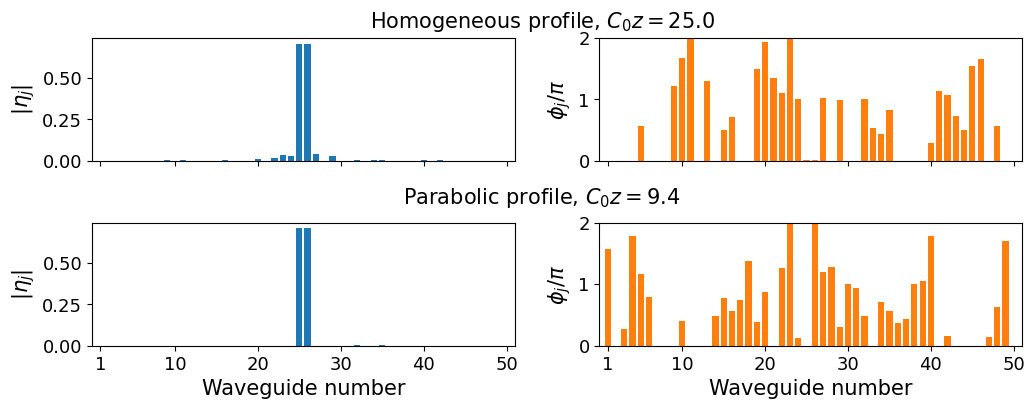

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 4))

waveguide_number = np.linspace(1, N, N)
axes[0, 0].bar(waveguide_number, pump_amp_homo, width=0.75)
axes[0, 1].bar(waveguide_number, pump_pha_homo / np.pi, width=0.75, color='C1')
axes[1, 0].bar(waveguide_number, pump_amp_para, width=0.75)
axes[1, 1].bar(waveguide_number, pump_pha_para / np.pi, width=0.75, color='C1')

xticks = [1, 10, 20, 30, 40, 50]

for j, ax in enumerate(axes.flatten()):
  ax.tick_params(axis='x', labelsize=13)
  ax.tick_params(axis='y', labelsize=13)
  ax.set_xlim(0, N + 1)
  if j % 2 == 0:
    ax.set_ylabel('$|\\eta_j|$', fontsize=15)
  else:
    ax.set_ylabel('$\\phi_j / \\pi$', fontsize=15)
    ax.set_ylim(0, 2)
  if j < 2:
    ax.set_xticks(xticks, [])
  else:
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel('Waveguide number', fontsize=15)

plt.figtext(0.5, 0.92, f'Homogeneous profile, $C_0z=${z_homo:.1f}', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.48, f'Parabolic profile, $C_0z=${z_para:.1f}', fontsize=15, ha='center', va='center')

fig.subplots_adjust(hspace=0.5)
plt.show()

Figure 3

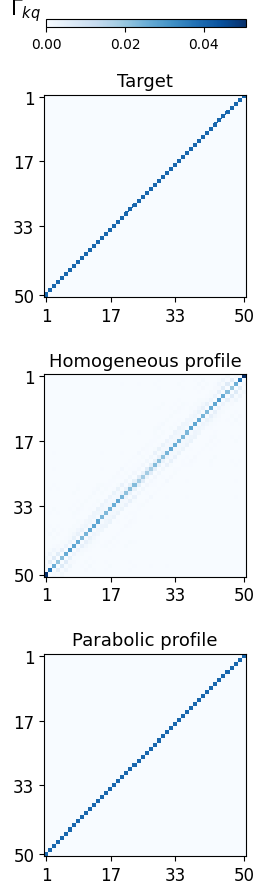

In [ ]:
fig = plt.figure(figsize=(2.5, 8.2), layout="constrained")
spec = fig.add_gridspec(3, 1, hspace=0.10)

ax0 = fig.add_subplot(spec[0])
ax1 = fig.add_subplot(spec[1])
ax2 = fig.add_subplot(spec[2])

vmax = max(corr_ideal.max(), corr_homo.max(), corr_para.max())
pc1 = ax0.pcolor(corr_ideal, vmin=0, vmax=vmax, cmap='Blues')
cbar_ax = fig.add_axes([0.15, 1.05, 0.8, 0.01])
cbar = fig.colorbar(pc1, cax=cbar_ax, orientation='horizontal')
pc2 = ax1.pcolor(corr_homo, vmin=0, vmax=vmax, cmap='Blues')
pc3 = ax2.pcolor(corr_para, vmin=0, vmax=vmax, cmap='Blues')

for i, ax in enumerate([ax0, ax1, ax2]):
  ax.set_yticks(xticks, xlabels, fontsize=12)
  ax.set_xticks(xticks, xlabels, fontsize=12)

ax0.set_title('Target', fontsize=13)
ax1.set_title('Homogeneous profile', fontsize=13)
ax2.set_title('Parabolic profile', fontsize=13)
for axis in [ax0, ax1, ax2]: axis.yaxis.set_inverted(True)
cbar.ax.tick_params(axis='y', labelsize=11)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('$\\Gamma_{{kq}}$', rotation=0, fontsize=15)

plt.show()

## Antidiagonal correlation matrix with equal nonvanishing entries ($N=100$)

In [ ]:
# Pump profiles and z positions obtained after optimization

# For homogeneous coupling profile:
z_homo = 50.0
pump_amp_homo = np.array([6.538497339098141e-05, 0.00038728174574449345, 0.0, 0.0006537007319798796, 0.0015057538763053131, 0.0, 0.0, 0.0014257124696678187, 0.0, 0.0, 0.001829463922328183, 0.0, 0.0, 0.002003480246604959, 0.0007062282907915132, 0.0, 0.0018099781443583558, 0.001521143628820639, 0.0, 0.00102645698391535, 0.0015865865910587005, 0.0, 0.0008950761866190495, 0.002607824727891647, 0.0, 0.00040876480150684694, 0.002242001770069964, 0.0, 0.0, 0.002864891519540417, 0.0, 0.0, 0.0025867719177610836, 0.0, 0.0, 0.0045484124656928904, 0.0, 0.0, 0.003537528872467363, 0.0008601643725709757, 0.0, 0.008071570579030194, 0.0, 0.0, 0.0051658542407106165, 0.004015645192964745, 0.0, 0.034639027108402054, 0.0, 0.7061428737067011, 0.7061020278095768, 0.0, 0.03469865724876453, 0.0, 0.0038585208500004522, 0.005008769446110767, 0.0, 0.0, 0.008040256269469023, 0.0, 0.0009153219048054053, 0.0034637024166909868, 0.0, 0.0, 0.00456444242630296, 0.0, 0.0, 0.0026406887628702904, 0.0, 0.0, 0.0028260715570482924, 0.0, 0.0, 0.00220184778135362, 0.0003264570952885831, 0.0, 0.00254159431968202, 0.0008284697727612493, 0.0, 0.0015497397205860353, 0.0009878998653785418, 0.0, 0.0015248880809626156, 0.0018017349467714897, 0.0, 0.0007120639988100992, 0.002004521730635387, 0.0, 0.0, 0.0018475331894521386, 0.0, 0.0, 0.0014179667500230579, 0.0, 0.0, 0.0014470223085795524, 0.000546430358713497, 0.0, 0.00040609332815456505, 4.149099150980473e-05])
pump_pha_homo = np.array([3.1416055338994058, 3.141588833549131, 3.141592612413614, 3.141590500443587, 3.141606552825005, 3.1415875572162952, 3.1415967856034412, 3.1415840456342923, 3.141585108129926, 3.1415813073317302, 3.141582046735152, 3.1416047588359812, 3.141581793135265, 3.141580691467096, 3.1415805932770593, 3.1415840815179834, 3.141597085572975, 3.1415813644049035, 3.141575386526956, 3.1415944539899794, 3.1416025388946025, 3.141575789864103, 3.1415969184968526, 3.141588076281029, 3.141579749161888, 3.1415806477185613, 3.1415943304484535, 3.1415749670186583, 3.1415995636841827, 3.1415967104165023, 3.1416079022788344, 3.1416039536465017, 3.1415970739278696, 3.141594314763151, 3.141582218485773, 3.1415759022632823, 3.141565424285976, 3.141574517864924, 3.14159390555649, 3.1415797035276802, 3.1415956642618497, 3.1415888028418766, 3.1415912323190414, 3.141584805311516, 3.1415940438951, 3.141581467846049, 3.141594567751421, 3.1415991450823166, 3.1415922253201973, 3.141592095425221, 3.141592486884115, 3.141592652399464, 3.141581157682819, 3.1415903361651436, 3.141591985814025, 3.141593291322337, 3.1415947441527887, 3.141604193667976, 3.141591786822702, 3.1416152695560657, 3.141591550187821, 3.14159812088276, 3.141583976937852, 3.141581468257777, 3.141605484409326, 3.141602036471325, 3.1415837685706305, 3.1415775874761227, 3.141596270629198, 3.1416048214588628, 3.141588133338091, 3.141608037541508, 3.1415862105433385, 3.141590840350288, 3.141590802848173, 3.141576922997419, 3.1416067704692026, 3.1415824416195743, 3.1415951768776114, 3.1415805407208772, 3.1415934245553747, 3.1415844193911995, 3.141597306295049, 3.141583409992233, 3.14159053507378, 3.1416150346524563, 3.1415824027689774, 3.1415944432224134, 3.141607102088522, 3.1415959842295913, 3.141590977072125, 3.141594332113395, 3.1416063172758735, 3.141583229039129, 3.1415882192546762, 3.141597923123658, 3.141588248409601, 3.141595988398402, 3.1415934501632177, 3.14160967950989])

# For parabolic coupling profile:
z_para = 9.425963107903456
pump_amp_para = np.array([0.0, 0.0, 0.0004256898350432788, 0.0001779108287181677, 0.0, 4.449965110574364e-07, 0.0, 0.00018548402193890434, 0.0, 0.00010316676831883985, 0.0, 6.0025693564743305e-05, 0.0, 9.625646052609617e-05, 4.659476825374913e-06, 9.640887379046113e-05, 6.803156734565488e-05, 0.00014146255992995, 0.0, 0.00016932026379110234, 0.0, 9.216796432971515e-05, 0.00028936018581295146, 0.00010725726789261972, 0.00022836541490031247, 0.0, 0.0004851842256437836, 4.6643040584056556e-05, 0.0, 0.0, 0.0, 0.0003748565517099818, 0.0, 0.0, 0.0, 0.0002288460111576777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00020402627599621628, 0.0, 0.0, 4.577329544080602e-05, 0.0, 5.8309623334078805e-05, 0.0, 0.7075327059664149, 0.706676084283694, 0.0, 0.00013336578390942696, 9.076194251859023e-05, 0.0, 0.0, 6.074213521022508e-06, 0.0, 0.0002712500616336913, 0.0, 0.0, 0.0, 5.7171998383243434e-05, 0.0, 0.0, 0.0003275236803981433, 0.0003884085104442374, 0.00034155902185628275, 0.0, 0.0, 0.00021214133436418508, 2.9242242657295098e-05, 3.932095722583232e-06, 0.0, 0.0009446165105343254, 0.0002983222857019633, 8.596541804785358e-05, 8.500621175308446e-06, 0.0002312290111161433, 0.000271853054739156, 0.00014754208421202927, 0.0003190564214586839, 0.00011186699596991024, 0.0, 0.00018447989919557779, 0.0, 0.0001111462572023167, 0.0, 0.0004798077892578821, 0.001021883321636563, 0.00015003320892173602, 0.0, 0.00010874500907144057, 0.0, 9.046311784356916e-05, 0.00016593728236572323, 0.000981331715820035, 0.0009013295569159417, 0.0006876921398470598, 0.0])
pump_pha_para = np.array([3.1415926695604903, 3.141592662255384, 3.1415926531344596, 3.141592650961884, 3.1415926586153, 3.1415926539133974, 3.1415926520566417, 3.1415926674203023, 3.141592661087567, 3.141592638176926, 3.1415926542789574, 3.141592658918556, 3.1415926461550088, 3.1415926533429874, 3.1415926469810684, 3.141592673003592, 3.141592658265134, 3.141592653016598, 3.141592641242633, 3.1415926496593567, 3.1415926476365668, 3.1415926503236093, 3.1415926669585645, 3.1415926647586803, 3.1415926623221604, 3.1415926418621773, 3.141592655687144, 3.1415926620395354, 3.141592651995985, 3.1415926530125353, 3.141592651419858, 3.1415926538273085, 3.141592643945817, 3.1415926630456235, 3.141592644897855, 3.1415926489616224, 3.1415926636095173, 3.1415926636169775, 3.14159265081859, 3.14159266131274, 3.1415926532635763, 3.1415926570382133, 3.141592656102535, 3.141592660087743, 3.141592650029227, 3.1415926593355317, 3.141592653344954, 3.1415926426094964, 3.141592660729997, 3.1415924809871925, 3.141592480213069, 3.141592655860059, 3.141592655358073, 3.141592661441694, 3.141592649589748, 3.14159265781587, 3.141592662812516, 3.141592645474652, 3.1415926551649056, 3.1415926607258586, 3.141592649786473, 3.141592644911941, 3.141592654736192, 3.141592652901144, 3.1415926599970274, 3.141592659207228, 3.1415926673520507, 3.1415926568969286, 3.141592653946319, 3.1415926514107784, 3.1415926604601503, 3.1415926554820732, 3.1415926536227436, 3.1415926570599932, 3.141592663274687, 3.141592661110192, 3.1415926549500157, 3.141592652974908, 3.141592658875956, 3.1415926644415295, 3.141592651639452, 3.1415926584684803, 3.141592657674516, 3.141592648512717, 3.1415926582760627, 3.1415926653733037, 3.141592668408465, 3.1415926436580346, 3.1415926501304616, 3.14159264579975, 3.1415926597044916, 3.1415926439738446, 3.1415926761633104, 3.141592670054756, 3.141592656713638, 3.14159265098081, 3.1415926578192166, 3.141592658382132, 3.141592651196571, 3.1415926477187677])

# For square-root profile:
z_sqrt = 3.7361234832007733
pump_amp_sqrt = np.array([0.006354671957147804, 0.001561252708196135, 0.04668735317853982, 0.005883541299835604, 0.000230833072997932, 0.030783460253584204, 0.0, 0.0, 0.0075227564150401405, 0.0, 0.0, 0.002714960570462936, 0.0, 0.0006918288714742603, 0.0, 0.007536071616191426, 0.0, 0.001405889134109265, 0.0, 0.001895765581057593, 0.005168993206252459, 0.00016924090706886327, 0.00441995986037546, 0.0, 0.0, 0.009742544711117908, 0.0056346744680769, 0.012334909127300809, 0.0, 0.0, 0.0, 0.0, 0.009892749751449242, 0.03157064774500194, 0.028819744851915574, 0.004565592857935172, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12633676900274984, 0.1644606796388565, 0.1664476563472451, 0.2514213853567717, 0.33384531551935054, 0.29236734088845207, 0.40454974694685775, 0.40440630255804677, 0.292317311083853, 0.33356667787142247, 0.25160318947934496, 0.16658078221900052, 0.164254636774502, 0.12640952904674596, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004803089378817519, 0.028665115225977988, 0.031770318140188235, 0.010025468120211866, 0.0, 0.0, 0.0, 0.0, 0.012034178860460163, 0.0055636639431037105, 0.009226242794727915, 0.0, 0.0, 0.004585832203603786, 0.00038870463792378056, 0.004934310356474795, 0.002479854726676401, 0.0, 0.00225377608910079, 0.0, 0.0076891090769607645, 0.0, 0.00093502874616981, 0.0, 0.002906116798847462, 0.0, 0.0, 0.006968246378252423, 0.0010390663994435546, 0.0, 0.030900251013821694, 0.00023208021803775591, 0.005880980807988952, 0.04673375883758361, 0.0015690564779116084, 0.006355817828621096])
pump_pha_sqrt = np.array([3.1408286254440103, 3.1415962409802103, 3.14471226703942, 3.1412129511858162, 3.146568532990957, 3.1441098945683676, 3.149799459739291, 3.1472942666051402, 3.1436836107953883, 3.129021255302084, 3.1270806033269203, 3.1499336133460414, 3.1399768955759444, 3.14249142457809, 3.1611881095828407, 3.135470400197642, 3.156013305458829, 3.136946853200689, 3.1437958026766943, 3.1347406067461856, 3.1189673114798797, 3.1611441053364175, 3.11590773841999, 3.143177518021305, 3.1346543540835246, 3.137274178122818, 3.143680262190058, 3.049446107126273, 3.138180437558143, 3.20783897395551, 3.0999301707939755, 3.1187950082317735, 3.1515421807855906, 3.1013284773170096, 3.1582095503801884, 3.1411441930273747, 3.0135402402803453, 3.0262476096088218, 3.1410184596660313, 3.090020207493824, 2.9577212914489746, 3.0202631476884445, 3.04360518869514, 1.944737600068478, 2.0560159920065817, 2.4549155762273105, 3.1755003969149596, 3.5201741572123746, 4.240691178627411, 4.961506493523966, 4.961284371256533, 4.240718574075585, 3.52030453331278, 3.175457028870114, 2.455155607629541, 2.055466509050483, 1.9447284278860733, 3.0436045141376833, 3.0202654608345516, 2.9577173641674337, 3.090019532286238, 3.141016432020169, 3.0262432435763706, 3.0135371093902847, 3.141169612457636, 3.158228750655921, 3.101276855311717, 3.1514199853061062, 3.118739517921932, 3.0999091845032534, 3.2078411910477698, 3.138179875918301, 3.0493233261474555, 3.143708673664422, 3.137665364308038, 3.1347308241161915, 3.143177897345005, 3.115913852160198, 3.161142782452256, 3.1192044043283023, 3.134716725911045, 3.14379547475825, 3.1369499354617165, 3.1560049880987275, 3.1356016871249826, 3.1611656515721496, 3.142429824090391, 3.1399693267472863, 3.149920492256627, 3.127080903899958, 3.1290181743557306, 3.143683036090813, 3.1472744799964336, 3.149796299521508, 3.14411499740212, 3.146566542668219, 3.1412120741704443, 3.144718776375227, 3.1415920233368153, 3.1408183999275447])

# Make phases zero for null injections
pump_pha_homo = np.where(pump_amp_homo, pump_pha_homo, 0)
pump_pha_para = np.where(pump_amp_para, pump_pha_para, 0)
pump_pha_sqrt = np.where(pump_amp_sqrt, pump_pha_sqrt, 0)

In [ ]:
# Parameters
N = len(pump_amp_homo)
C0 = 1
L = 20 / C0
g = 1
alpha = 1

transf_data_homo = transform(N)
f_para = [np.sqrt((i + 1) * (N - 1 - i)) / 2  for i in range(N - 1)] # parabolic coupling profile
transf_data_para = transform(f=f_para, default=False)
f_sqrt = [np.sqrt(i + 1) for i in range(N - 1)]                      # square-root coupling profile
transf_data_sqrt = transform(f=f_sqrt, default=False)

pump_homo = [i*np.exp(1j * j) for i, j in zip(pump_amp_homo, pump_pha_homo)]
pump_data_homo = eta(pump=pump_homo, default=False)
pump_para = [i*np.exp(1j * j) for i, j in zip(pump_amp_para, pump_pha_para)]
pump_data_para = eta(pump=pump_para, default=False)
pump_sqrt = [i*np.exp(1j * j) for i, j in zip(pump_amp_sqrt, pump_pha_sqrt)]
pump_data_sqrt = eta(pump=pump_sqrt, default=False)

nonzero_coeffs = [(i, j) for i in range(N) for j in range(N) if i == N - 1 - j]
corr_ideal = create_target(N, nonzero_coeffs)

corr_homo = corr(JSA(s2i(Q_s(z_homo, C0, g, alpha, pump_data_homo, transf_data_homo, add_matrices=False), transf_data_homo)))
corr_para = corr(JSA(s2i(Q_s(z_para, C0, g, alpha, pump_data_para, transf_data_para, add_matrices=False), transf_data_para)))
corr_sqrt = corr(JSA(s2i(Q_s(z_sqrt, C0, g, alpha, pump_data_sqrt, transf_data_sqrt, add_matrices=False), transf_data_sqrt)))

sim_homo = similarity(corr_ideal, corr_homo)
sim_para = similarity(corr_ideal, corr_para)
sim_sqrt = similarity(corr_ideal, corr_sqrt)

print(f'For homogeneous coupling, similarity = {sim_homo:.4f}')
print(f'For parabolic coupling, similarity = {sim_para:.4f}')
print(f'For square-root coupling, similarity = {sim_sqrt:.5f}')

For homogeneous coupling, similarity = 0.6345
For parabolic coupling, similarity = 0.9999
For square-root coupling, similarity = 0.10602


Figure 5S

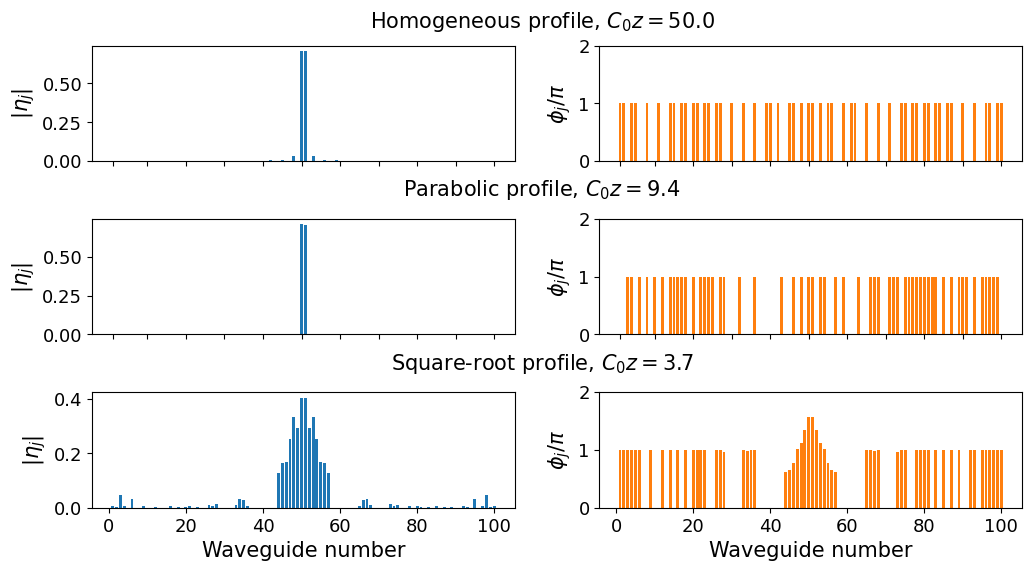

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

waveguide_number = np.linspace(1, N, N)
axes[0, 0].bar(waveguide_number, pump_amp_homo, width=0.75)
axes[0, 1].bar(waveguide_number, pump_pha_homo / np.pi, width=0.75, color='C1')
axes[1, 0].bar(waveguide_number, pump_amp_para, width=0.75)
axes[1, 1].bar(waveguide_number, pump_pha_para / np.pi, width=0.75, color='C1')
axes[2, 0].bar(waveguide_number, pump_amp_sqrt, width=0.75)
axes[2, 1].bar(waveguide_number, pump_pha_sqrt / np.pi, width=0.75, color='C1')

xticks = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for j, ax in enumerate(axes.flatten()):
  ax.tick_params(axis='x', labelsize=13)
  ax.tick_params(axis='y', labelsize=13)
  if j % 2 == 0:
    ax.set_ylabel('$|\\eta_j|$', fontsize=15)
  else:
    ax.set_ylabel('$\\phi_j / \\pi$', fontsize=15)
    ax.set_ylim(0, 2)
  if j < 4:
    ax.set_xticks(xticks, [])
  else:
    ax.set_xlabel('Waveguide number', fontsize=15)

plt.figtext(0.5, 0.92, f'Homogeneous profile, $C_0z=${z_homo:.1f}', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.64, f'Parabolic profile, $C_0z=${z_para:.1f}', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.35, f'Square-root profile, $C_0z=${z_sqrt:.1f}', fontsize=15, ha='center', va='center')

fig.subplots_adjust(hspace=0.5)  # Set custom spacing
plt.show()

Figure 6S

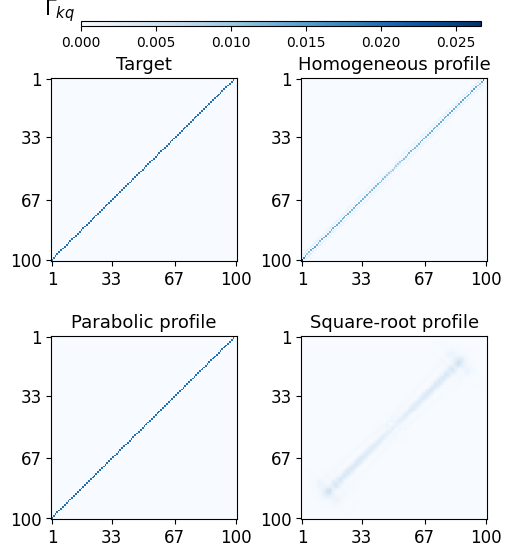

In [ ]:
fig = plt.figure(figsize=(5, 5), layout="constrained")
spec = fig.add_gridspec(2, 2, hspace=0.10)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[1, 1])

vmax = max(corr_ideal.max(), corr_homo.max(), corr_para.max())
pc1 = ax0.pcolor(corr_ideal, vmin=0, vmax=vmax, cmap='Blues')
cbar_ax = fig.add_axes([0.15, 1.05, 0.8, 0.01])
cbar = fig.colorbar(pc1, cax=cbar_ax, orientation='horizontal')
pc2 = ax1.pcolor(corr_homo, vmin=0, vmax=vmax, cmap='Blues')
pc3 = ax2.pcolor(corr_para, vmin=0, vmax=vmax, cmap='Blues')
pc3 = ax3.pcolor(corr_sqrt, vmin=0, vmax=vmax, cmap='Blues')

for i, ax in enumerate([ax0, ax1, ax2, ax3]):
  ax.set_yticks(xticks, xlabels, fontsize=12)
  ax.set_xticks(xticks, xlabels, fontsize=12)

ax0.set_title('Target', fontsize=13)
ax1.set_title('Homogeneous profile', fontsize=13)
ax2.set_title('Parabolic profile', fontsize=13)
ax3.set_title('Square-root profile', fontsize=13)
for axis in [ax0, ax1, ax2, ax3]: axis.yaxis.set_inverted(True)
cbar.ax.tick_params(axis='y', labelsize=11)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('$\\Gamma_{{kq}}$', rotation=0, fontsize=15)

plt.show()

## Diagonal correlation matrix  with equal nonvanishing entries ($N=50$)

In [ ]:
# Pump profiles and z positions obtained after optimization

# For homogeneous coupling profile:
z_homo = 21.378472928085895
pump_amp_homo = np.array([0.17709704326132605, 0.0, 0.22396403943660356, 0.0, 0.0, 0.2101946588555353, 0.22298548155624065, 0.0, 0.20685466227925808, 0.1328039338618598, 0.0, 0.17626066384455819, 0.10148450358861327, 0.1821512785847202, 0.08072662796730236, 0.16547899322060436, 0.0, 0.20135498348709427, 0.0, 0.18807271348922605, 0.1502819247836489, 0.1439757620132633, 0.0870000827221537, 0.0, 0.2251514438079082, 0.044179127134412854, 0.17914405306577438, 0.10972112637697927, 0.18365785706079582, 0.0, 0.0, 0.18413236944023878, 0.1992554662083296, 0.14829071497841123, 0.0, 0.2085035544620556, 0.12250569850998312, 0.011423342767448802, 0.20051017361834783, 0.01251982159516056, 0.14149302780929346, 0.21301832899969905, 0.014427489454411694, 0.1001090446712238, 0.22480009397127432, 0.0, 0.16769362023315218, 0.02053509208117771, 0.16066438732928748, 0.15266843389853493])
pump_pha_homo = np.array([5.590659637321307, 5.6098714110987045, 5.9352750278706985, 4.8753158145920406, 2.5260241442633378, 2.494608505920142, 0.0, 6.043322030344143, 5.959002259831331, 2.7606382267126683, 4.654536408710497, 2.673887488018228, 0.5075162246059922, 2.4975859856371487, 0.6828272061038548, 2.5408158033632917, 3.2951625313220996, 2.9464678879105493, 4.3114098947944095, 2.5537158400931435, 0.40275432867943556, 2.5424462167177375, 5.222214054184217, 5.888367518928064, 5.882199532496737, 1.3989545230737095, 0.0, 2.732413866033712, 0.0, 6.283185307179586, 3.7267573783392334, 3.101058711188802, 5.720954399366571, 2.427609030665186, 2.5177273995393246, 2.5186420007806998, 0.13710964889484892, 3.922465821214154, 5.691868653119655, 4.298857277249234, 5.423108079661381, 2.790419915966971, 4.308774512397325, 3.2708342030187323, 5.822128880282157, 0.4722122092247209, 5.929213957999603, 1.7147727628453175, 0.0, 2.931560719787892])

# For parabolic coupling profile:
z_para = 24.128249642092513
pump_amp_para = np.array([0.15011699469792628, 0.11066713480315676, 0.0, 0.0, 0.15926773789708762, 0.1167789038419238, 0.0, 0.0, 0.00774412685029831, 0.022850262595263942, 0.13718081154929365, 0.17095317413145436, 0.2563161889728211, 0.11433241003356175, 0.08090070213811763, 0.256543396942087, 0.0, 0.24601469049781838, 0.2516642231433967, 0.09520656934094018, 0.21328617419045412, 0.0, 0.07652332962430601, 0.12284920283591418, 0.18444299025142663, 0.02432911603267913, 0.04359330210938887, 0.24554361143621242, 0.11240188841475146, 0.003497395451763868, 0.006046121614924077, 0.11415467738918467, 0.18489748274672718, 0.1040785552622486, 0.16727912612211213, 0.23357120312456317, 0.1646617582583106, 0.006028844098826614, 0.21614880642461157, 0.02196657373886397, 0.2125213787861435, 0.21743548855179073, 0.0, 0.17438807411499255, 0.059445118613858906, 0.03699557746502748, 0.033700946189365005, 0.2624903984177386, 0.027062602157762808, 0.06437546982397821])
pump_pha_para = np.array([4.101270482788576, 6.283185307179586, 0.23272282650185827, 2.9847180980914176, 4.2554785729860205, 1.2019527579038207, 0.6258150599278995, 4.566612074334283, 0.3291494611811856, 1.6964939801008807, 3.40655494721953, 6.0089673048450285, 4.895170678855671, 0.46852936683970164, 1.0540229745476735, 1.748403853944531, 0.647988698118076, 6.283185307179586, 4.442846319159226, 1.0156569084673532, 3.874042740762385, 5.91868559312111, 5.957090327992807, 1.0503587441359843, 4.520600434963619, 5.09819731868418, 2.617797550125224, 1.6684032128936166, 2.849660349284673, 5.210031366084904, 1.667180848092792, 6.263465256803513, 0.0, 2.6948764205994316, 2.832089287299905, 1.4165384474594152, 3.107127590126803, 4.687227981097658, 5.572672962166893, 5.479313928866475, 4.694326371144138, 0.8633089912470779, 1.298131454873991, 1.1967645417472956, 5.358028937110808, 1.1736969120110143, 2.748144832952015, 1.1474494347953625, 2.8884878774066034, 2.4197318186751056])

# For square-root profile:
z_sqrt = 0.0025853726353762428
pump_amp_sqrt = np.array([0.1414221556696058, 0.14141563593751558, 0.1414152097509073, 0.14141435571395047, 0.1414155462125902, 0.14141727689540923, 0.14141474499471415, 0.14141467944332922, 0.14140868293974038, 0.14141648585970362, 0.1414137292472627, 0.14140688560480763, 0.14141142394427314, 0.14141981094646316, 0.14142960239305646, 0.1414330277170202, 0.14143167858720634, 0.14143496755361432, 0.14142580471426805, 0.1414191547964241, 0.1414334557140206, 0.141434232632317, 0.14141967589611862, 0.1414294987891335, 0.14143327520321994, 0.14142590908240577, 0.1414249588551436, 0.14143401345424567, 0.1414367765461218, 0.14144302170825587, 0.14143791892052396, 0.14144121149240899, 0.14143441514203522, 0.14142771268985468, 0.14142821698492425, 0.14141673832968907, 0.14140968550150015, 0.14140986005826317, 0.14141387711654008, 0.14141309312699904, 0.14140500672321266, 0.1414099897486047, 0.14141344121630636, 0.1414124392214448, 0.14140986590072135, 0.1414152048218314, 0.14141885005949756, 0.1414154070247745, 0.14141795735379692, 0.1414212264499225])
pump_pha_sqrt = np.array([2.339098012200669, 0.08098218677124071, 1.8319745960320577, 4.592859291967795, 5.860096538427325, 5.26151208206552, 3.7960439249176714, 4.647935475782126, 1.9860767957503411, 5.935174615147559, 4.557823611879652, 1.9156324734263095, 5.5834125962414545, 3.4459067679275446, 3.3830143559595225, 2.735251553450932, 3.553352096051558, 4.593662753294879, 4.830796134718669, 0.7974525848805252, 2.5307314816494233, 1.9677876440521447, 3.5616938336211628, 5.91354932329245, 6.274373774302864, 1.8221840409791006, 3.4967857037312515, 1.6559039122795856, 1.1578904506970937, 2.279224943985842, 2.4352670631620192, 3.0352092006466056, 3.069345266242295, 3.915162139236928, 2.5430320434407516, 3.611898751701963, 0.4260116643987062, 4.210147641563527, 0.08153870640893666, 5.512595673626874, 2.9349024383097055, 5.783597608347813, 1.2018857801163387, 2.4742367837544315, 5.445096979024739, 0.04863565509266491, 5.925568006786597, 5.143318055936949, 2.388706968882746, 0.8205519733737426])

# Make phases zero for null injections
pump_pha_homo = np.where(pump_amp_homo, pump_pha_homo, 0)
pump_pha_para = np.where(pump_amp_para, pump_pha_para, 0)
pump_pha_sqrt = np.where(pump_amp_sqrt, pump_pha_sqrt, 0)

In [ ]:
# Parameters
N = len(pump_amp_homo)
C0 = 1
L = 20 / C0
g = 1
alpha = 1

transf_data_homo = transform(N)
f_para = [np.sqrt((i + 1) * (N - 1 - i)) / 2  for i in range(N - 1)] # parabolic coupling profile
transf_data_para = transform(f=f_para, default=False)
f_sqrt = [np.sqrt(i + 1) for i in range(N - 1)]                      # square-root coupling profile
transf_data_sqrt = transform(f=f_sqrt, default=False)

pump_homo = [i*np.exp(1j * j) for i, j in zip(pump_amp_homo, pump_pha_homo)]
pump_data_homo = eta(pump=pump_homo, default=False)
pump_para = [i*np.exp(1j * j) for i, j in zip(pump_amp_para, pump_pha_para)]
pump_data_para = eta(pump=pump_para, default=False)
pump_sqrt = [i*np.exp(1j * j) for i, j in zip(pump_amp_sqrt, pump_pha_sqrt)]
pump_data_sqrt = eta(pump=pump_sqrt, default=False)

nonzero_coeffs = [(i, j) for i in range(N) for j in range(N) if i == j]
corr_ideal = create_target(N, nonzero_coeffs)

corr_homo = corr(JSA(s2i(Q_s(z_homo, C0, g, alpha, pump_data_homo, transf_data_homo, add_matrices=False), transf_data_homo)))
corr_para = corr(JSA(s2i(Q_s(z_para, C0, g, alpha, pump_data_para, transf_data_para, add_matrices=False), transf_data_para)))
corr_sqrt = corr(JSA(s2i(Q_s(z_sqrt, C0, g, alpha, pump_data_sqrt, transf_data_sqrt, add_matrices=False), transf_data_sqrt)))

sim_homo = similarity(corr_ideal, corr_homo)
sim_para = similarity(corr_ideal, corr_para)
sim_sqrt = similarity(corr_ideal, corr_sqrt)

print(f'For homogeneous coupling, similarity = {sim_homo:.5f}')
print(f'For parabolic coupling, similarity = {sim_para:.5f}')
print(f'For square-root coupling, similarity = {sim_sqrt:.5f}')

For homogeneous coupling, similarity = 0.95481
For parabolic coupling, similarity = 0.96539
For square-root coupling, similarity = 0.99974


Figure 7S

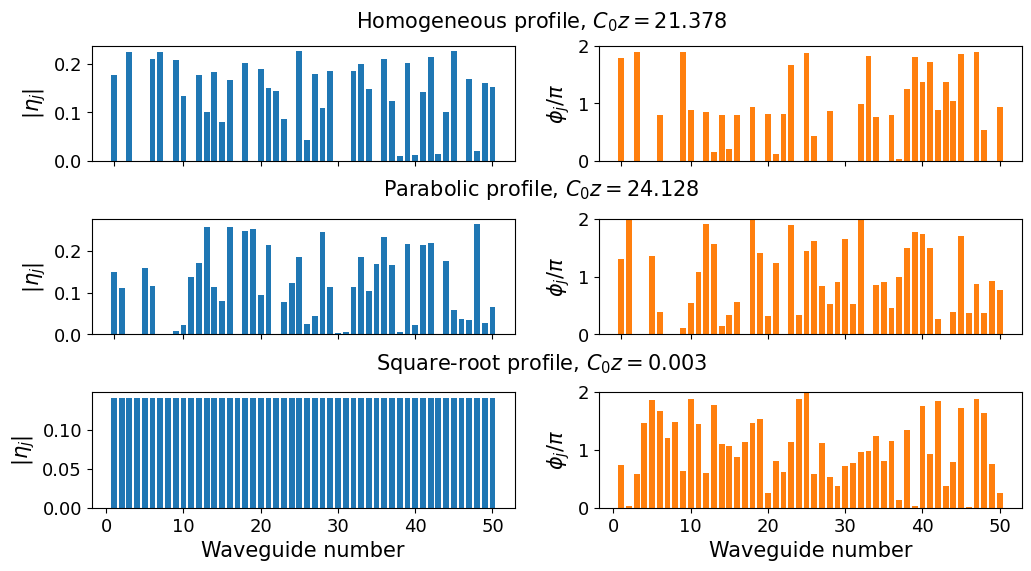

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

waveguide_number = np.linspace(1, N, N)
axes[0, 0].bar(waveguide_number, pump_amp_homo, width=0.75)
axes[0, 1].bar(waveguide_number, pump_pha_homo / np.pi, width=0.75, color='C1')
axes[1, 0].bar(waveguide_number, pump_amp_para, width=0.75)
axes[1, 1].bar(waveguide_number, pump_pha_para / np.pi, width=0.75, color='C1')
axes[2, 0].bar(waveguide_number, pump_amp_sqrt, width=0.75)
axes[2, 1].bar(waveguide_number, pump_pha_sqrt / np.pi, width=0.75, color='C1')

xticks = [1, 10, 20, 30, 40, 50]

for j, ax in enumerate(axes.flatten()):
  ax.tick_params(axis='x', labelsize=13)
  ax.tick_params(axis='y', labelsize=13)
  if j % 2 == 0:
    ax.set_ylabel('$|\\eta_j|$', fontsize=15)
  else:
    ax.set_ylabel('$\\phi_j / \\pi$', fontsize=15)
    ax.set_ylim(0, 2)
  if j < 4:
    ax.set_xticks(xticks, [])
  else:
    ax.set_xlabel('Waveguide number', fontsize=15)

plt.figtext(0.5, 0.92, f'Homogeneous profile, $C_0z=${z_homo:.3f}', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.64, f'Parabolic profile, $C_0z=${z_para:.3f}', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.35, f'Square-root profile, $C_0z=${z_sqrt:.3f}', fontsize=15, ha='center', va='center')

fig.subplots_adjust(hspace=0.5)  # Set custom spacing
plt.show()

Figure 8S

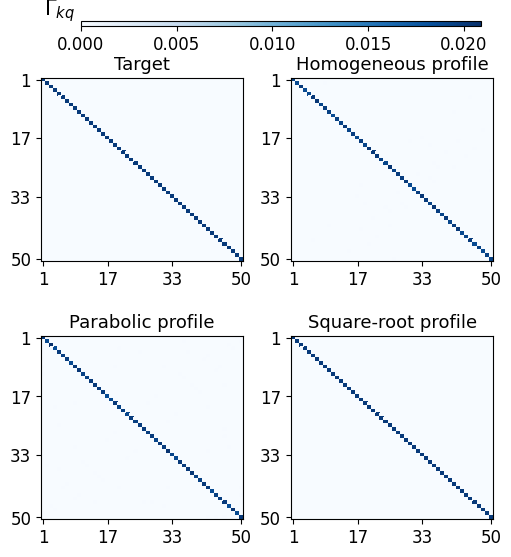

In [ ]:
fig = plt.figure(figsize=(5, 5), layout="constrained")
spec = fig.add_gridspec(2, 2, hspace=0.10)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[1, 1])

vmax = max(corr_ideal.max(), corr_homo.max(), corr_para.max())
pc1 = ax0.pcolor(corr_ideal, vmin=0, vmax=vmax, cmap='Blues')
cbar_ax = fig.add_axes([0.15, 1.05, 0.8, 0.01])
cbar = fig.colorbar(pc1, cax=cbar_ax, orientation='horizontal')
pc2 = ax1.pcolor(corr_homo, vmin=0, vmax=vmax, cmap='Blues')
pc3 = ax2.pcolor(corr_para, vmin=0, vmax=vmax, cmap='Blues')
pc3 = ax3.pcolor(corr_sqrt, vmin=0, vmax=vmax, cmap='Blues')

for i, ax in enumerate([ax0, ax1, ax2, ax3]):
  ax.set_yticks(xticks, xlabels, fontsize=12)
  ax.set_xticks(xticks, xlabels, fontsize=12)

ax0.set_title('Target', fontsize=13)
ax1.set_title('Homogeneous profile', fontsize=13)
ax2.set_title('Parabolic profile', fontsize=13)
ax3.set_title('Square-root profile', fontsize=13)
for axis in [ax0, ax1, ax2, ax3]: axis.yaxis.set_inverted(True)
cbar.ax.tick_params(axis='y', labelsize=11)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('$\\Gamma_{{kq}}$', rotation=0, fontsize=15)

plt.show()

## Correlation matrix with only odd individual modes and equal nonvanishing entries ($N=25$)

In [ ]:
# Pump profiles and z positions obtained after optimization

# For homogeneous coupling profile:
z_homo = 13.461727702282461
pump_amp_homo = np.array([0.18991707276612413, 0.16245690088749407, 0.18533994817176327, 0.19635298381526448, 0.2251970777611924, 0.21022585043577385, 0.19243919546487467, 0.19943582865094114, 0.22045272446327502, 0.19607473845837461, 0.20801457340869087, 0.1994365860215219, 0.21353784375684345, 0.19943138766731894, 0.20800868732576566, 0.19606395269926466, 0.2204579246631416, 0.19945193880004233, 0.19246468874433323, 0.21024885168526383, 0.22523530311570794, 0.1963781954817609, 0.18536096520193648, 0.16245872684370088, 0.18992413001448144])
pump_pha_homo = np.array([3.141592675415078, 3.141592694490552, 3.1415926787606114, 3.14159267766373, 3.1415926991465195, 3.141592678286852, 3.1415926573468242, 3.141592674356309, 3.141592674229555, 3.141592699659692, 3.1415926971542056, 3.1415926663871225, 3.1415926616326337, 3.141592678608547, 3.141592684855148, 3.141592678055556, 3.1415926796431854, 3.1415926783203463, 3.1415926588263465, 3.1415926699067067, 3.1415926864054105, 3.1415926781470684, 3.1415926442700104, 3.1415926759582433, 3.1415926561613894])

# For parabolic coupling profile:
z_para = 19.220087900810327
pump_amp_para = np.array([0.14492831748704002, 0.22944548538918066, 0.2931030733448087, 0.21493940348516666, 0.3159039967913798, 0.2128940014277384, 0.019228285418628248, 0.0, 0.0011696524344000467, 0.15268828363109055, 0.3170193564998886, 0.07803825828576189, 0.1322543752910117, 0.14079848907013942, 0.13170735985517612, 0.1421112191101214, 0.34204199462589424, 0.32076048794559925, 0.3409730900101262, 0.23390509943410728, 0.04764989655517547, 0.17806909855069467, 0.0, 0.02097310069840049, 0.13680586133288133])
pump_pha_para = np.array([1.579404615859496, 2.0433643343450325, 1.8981067789380406, 2.5516683938222466, 2.4772109880823896, 2.1943155773782625, 3.023807911405299, 3.351041870757635, 0.4966492519107089, 1.8189035274995249, 1.7110618895944647, 2.53956246947298, 1.638340894880809, 2.9607647600398703, 5.272716195016037, 2.362592967791358, 2.8693363577297517, 1.1610276692807924, 1.5934540786383735, 3.394155413051685, 3.968087156012721, 1.0924039035878843, 4.403408975017952, 3.7380028100706904, 2.7253937098451146])

# For square-root profile:
z_sqrt = 6.436912243511268
pump_amp_sqrt = np.array([0.6438843268445106, 0.10455208848164528, 0.06830726252307125, 0.0, 0.02560925904167073, 0.0512000769971739, 0.06618875530260432, 0.07152876188614726, 0.048373944915707213, 0.017277920835216228, 0.08920060769786085, 0.028952449495279236, 0.062027892742260136, 0.13795988839665213, 0.07515572675575921, 0.06798573350646832, 0.09290218773675918, 0.09730868798853709, 0.0, 0.05060302532612145, 0.06452574717292445, 0.01019887393190503, 0.0, 0.24275404895038818, 0.6546750209535068])
pump_pha_sqrt = np.array([2.8791727471030404, 6.283185307179586, 0.41304594757958707, 2.0564963834714667, 0.4898857927784035, 1.2871967925028334, 5.5510802765646705, 0.04286163648176136, 3.477848041215383, 0.0, 0.0020368166190197047, 0.0, 3.811077018713274, 4.8356837578812035, 1.1238026451668144, 5.354085366169913, 1.5019402712294503, 5.802934138716883, 2.8203131205331022, 0.27639570351724024, 0.0, 5.627374808138012, 3.3964365571528843, 6.283185307179586, 2.988854703825345])

# Make phases zero for null injections
pump_pha_homo = np.where(pump_amp_homo, pump_pha_homo, 0)
pump_pha_para = np.where(pump_amp_para, pump_pha_para, 0)
pump_pha_sqrt = np.where(pump_amp_sqrt, pump_pha_sqrt, 0)

In [ ]:
# Parameters
N = len(pump_amp_homo)
C0 = 1
L = 20 / C0
g = 1
alpha = 1

transf_data_homo = transform(N)
f_para = [np.sqrt((i + 1) * (N - 1 - i)) / 2  for i in range(N - 1)] # parabolic coupling profile
transf_data_para = transform(f=f_para, default=False)
f_sqrt = [np.sqrt(i + 1) for i in range(N - 1)]                      # square-root coupling profile
transf_data_sqrt = transform(f=f_sqrt, default=False)

pump_homo = [i*np.exp(1j * j) for i, j in zip(pump_amp_homo, pump_pha_homo)]
pump_data_homo = eta(pump=pump_homo, default=False)
pump_para = [i*np.exp(1j * j) for i, j in zip(pump_amp_para, pump_pha_para)]
pump_data_para = eta(pump=pump_para, default=False)
pump_sqrt = [i*np.exp(1j * j) for i, j in zip(pump_amp_sqrt, pump_pha_sqrt)]
pump_data_sqrt = eta(pump=pump_sqrt, default=False)

nonzero_coeffs = [(i, j) for i in range(N) for j in range(N) if i % 2 == 0 and j % 2 == 0]
corr_ideal = create_target(N, nonzero_coeffs)

corr_homo = corr(JSA(s2i(Q_s(z_homo, C0, g, alpha, pump_data_homo, transf_data_homo, add_matrices=False), transf_data_homo)))
corr_para = corr(JSA(s2i(Q_s(z_para, C0, g, alpha, pump_data_para, transf_data_para, add_matrices=False), transf_data_para)))
corr_sqrt = corr(JSA(s2i(Q_s(z_sqrt, C0, g, alpha, pump_data_sqrt, transf_data_sqrt, add_matrices=False), transf_data_sqrt)))

sim_homo = similarity(corr_ideal, corr_homo)
sim_para = similarity(corr_ideal, corr_para)
sim_sqrt = similarity(corr_ideal, corr_sqrt)

print(f'For homogeneous coupling, similarity = {sim_homo:.5f}')
print(f'For parabolic coupling, similarity = {sim_para:.5f}')
print(f'For square-root coupling, similarity = {sim_sqrt:.5f}')

For homogeneous coupling, similarity = 0.96914
For parabolic coupling, similarity = 0.78688
For square-root coupling, similarity = 0.35444


Figure 9S

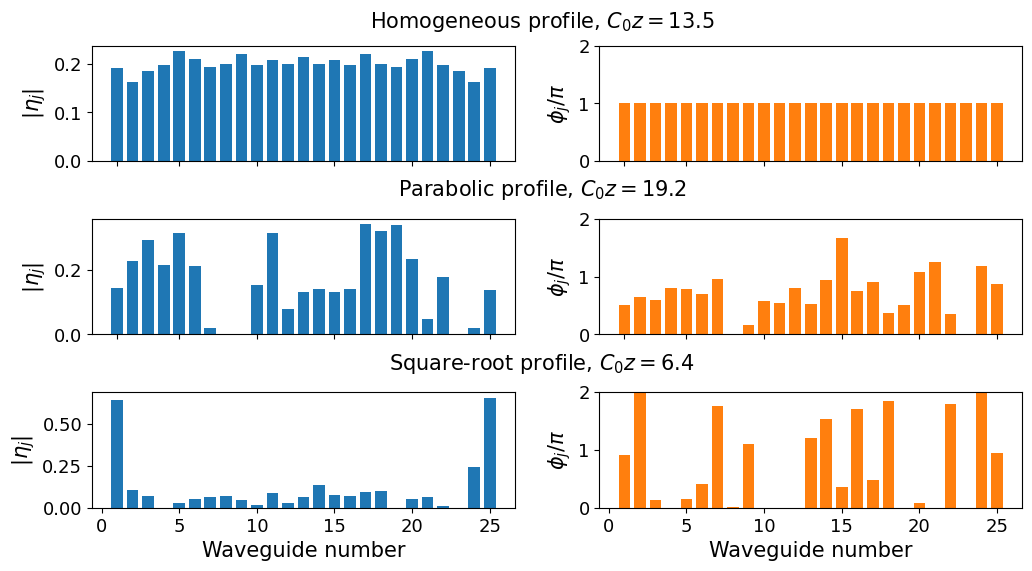

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

waveguide_number = np.linspace(1, N, N)
axes[0, 0].bar(waveguide_number, pump_amp_homo, width=0.75)
axes[0, 1].bar(waveguide_number, pump_pha_homo / np.pi, width=0.75, color='C1')
axes[1, 0].bar(waveguide_number, pump_amp_para, width=0.75)
axes[1, 1].bar(waveguide_number, pump_pha_para / np.pi, width=0.75, color='C1')
axes[2, 0].bar(waveguide_number, pump_amp_sqrt, width=0.75)
axes[2, 1].bar(waveguide_number, pump_pha_sqrt / np.pi, width=0.75, color='C1')


xticks = [1, 5, 10, 15, 20, 25]


for j, ax in enumerate(axes.flatten()):
  ax.tick_params(axis='x', labelsize=13)
  ax.tick_params(axis='y', labelsize=13)
  if j % 2 == 0:
    ax.set_ylabel('$|\\eta_j|$', fontsize=15)
  else:
    ax.set_ylabel('$\\phi_j / \\pi$', fontsize=15)
    ax.set_ylim(0, 2)
  if j < 4:
    ax.set_xticks(xticks, [])
  else:
    ax.set_xlabel('Waveguide number', fontsize=15)

plt.figtext(0.5, 0.92, f'Homogeneous profile, $C_0z=${z_homo:.1f}', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.64, f'Parabolic profile, $C_0z=${z_para:.1f}', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.35, f'Square-root profile, $C_0z=${z_sqrt:.1f}', fontsize=15, ha='center', va='center')

fig.subplots_adjust(hspace=0.5)  # Set custom spacing
plt.show()

Figure 10S

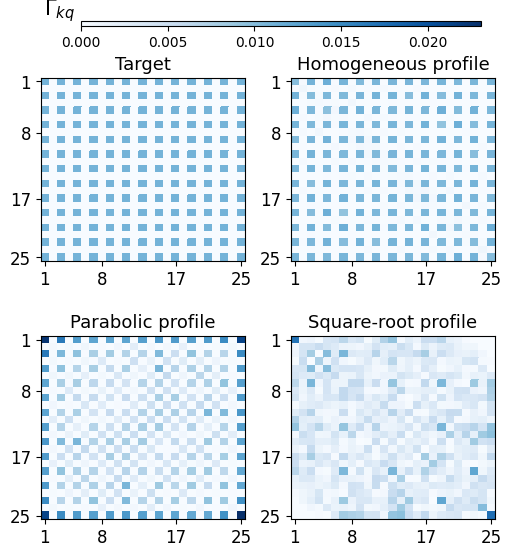

In [ ]:
fig = plt.figure(figsize=(5, 5), layout="constrained")
spec = fig.add_gridspec(2, 2, hspace=0.10)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[1, 1])

vmax = max(corr_ideal.max(), corr_homo.max(), corr_para.max())
pc1 = ax0.pcolor(corr_ideal, vmin=0, vmax=vmax, cmap='Blues')
cbar_ax = fig.add_axes([0.15, 1.05, 0.8, 0.01])
cbar = fig.colorbar(pc1, cax=cbar_ax, orientation='horizontal')
pc2 = ax1.pcolor(corr_homo, vmin=0, vmax=vmax, cmap='Blues')
pc3 = ax2.pcolor(corr_para, vmin=0, vmax=vmax, cmap='Blues')
pc3 = ax3.pcolor(corr_sqrt, vmin=0, vmax=vmax, cmap='Blues')

xticks = np.array([0.5, round(N/3) - 0.5, round(2*N/3) - 0.5, N - 0.5])
xlabels = np.array([1, round(N/3), round(2*N/3), N])

for i, ax in enumerate([ax0, ax1, ax2, ax3]):
  ax.set_yticks(xticks, xlabels, fontsize=12)
  ax.set_xticks(xticks, xlabels, fontsize=12)

ax0.set_title('Target', fontsize=13)
ax1.set_title('Homogeneous profile', fontsize=13)
ax2.set_title('Parabolic profile', fontsize=13)
ax3.set_title('Square-root profile', fontsize=13)
for axis in [ax0, ax1, ax2, ax3]: axis.yaxis.set_inverted(True)
cbar.ax.tick_params(axis='y', labelsize=12)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('$\\Gamma_{{kq}}$', rotation=0, fontsize=15)

plt.show()

## Supermode correlation matrix with only odd supermodes and equal nonvanishing entries  ($N=25$)

In [ ]:
# Pump profiles and z positions obtained after optimization

# For homogeneous coupling profile:
z_homo = 0.03762242982135676
pump_amp_homo = np.array([0.02709635414768624, 0.029402626496282926, 0.027157544940165375, 0.028914549644313427, 0.033051541188186845, 0.021723473943232235, 0.027163778821292117, 0.02046208873818785, 0.031873097926502655, 0.03610786477882426, 0.03063558198971821, 0.03016882932126311, 0.9896892155086768, 0.028321729576130744, 0.027051072871137553, 0.0216274784699317, 0.025926424634356734, 0.0374429666831517, 0.030738331048006138, 0.03610076394783623, 0.024853763792562204, 0.02890272234336534, 0.03054561078570835, 0.02830906079658968, 0.030696694058147664])
pump_pha_homo = np.array([3.1415791758479936, 3.1418245962568907, 3.1415408955208535, 3.141801622575151, 3.141446705345952, 3.1419096625158796, 3.1415316197932293, 3.141531199018881, 3.1416040650892674, 3.141596028284521, 3.141611885121893, 3.1415808670723875, 3.142657406281583, 3.141567209369502, 3.1416003871251417, 3.1417037124113367, 3.1416037548762636, 3.1416261209623237, 3.141599839213341, 3.1415139390568734, 3.141599443147683, 3.1414377298791183, 3.1416474449115763, 3.1401230708916974, 3.141580395316238])

# For parabolic coupling profile:
z_para = 12.656995010259415
pump_amp_para = np.array([0.0, 0.0, 0.003759496317899827, 0.2253519022587508, 0.011268251065910522, 0.0, 0.45693086994024334, 0.006486254013827392, 0.00877887201580225, 3.982891940760351e-07, 0.4872338061305426, 0.0, 0.0014242505165784679, 0.0017844053997679596, 0.49004128559140986, 0.002312332161085649, 0.013151397142925339, 0.0041072423200259195, 0.46180734591649614, 0.011816276201230425, 0.0034909288790557665, 0.22138644785444203, 0.001667682094393302, 0.0003802450137041524, 0.00031706719778726934])
pump_pha_para = np.array([4.5229716191363885, 0.30524091729112895, 2.170011336098818, 3.1691180712608626, 3.5298468621577284, 0.7136243984016337, 6.891343055591467e-05, 1.3932888830157213, 2.656250591174866, 1.1920576907154234, 4.718496472296137, 1.8303939269958993, 0.937212352299158, 4.152991183632365, 1.5930399104334176, 2.7607121495463494, 0.0, 3.156595169610909, 3.1299530027778464, 2.662270687081055, 5.305655744817729, 0.010771203443666657, 3.7971699975156024, 4.852872782906555, 1.368435028665908])

# For square-root profile:
z_sqrt = 0.3040251616719698
pump_amp_sqrt = np.array([0.19982775673621656, 0.014638469828877067, 0.0, 0.013412135705788673, 0.014657304140436377, 0.02710732069625499, 0.018482975690615543, 0.0, 0.03212546702580678, 0.0, 0.049509726481105715, 0.3688231171986169, 0.8809671004956662, 0.0, 0.048078793179761145, 0.01295739071638401, 0.0, 0.0, 0.0, 0.023379811952284286, 0.014443836295276385, 0.013909546105568896, 0.0, 0.02187230752288006, 0.19712958537389283])
pump_pha_sqrt = np.array([0.0, 1.1367994933455952, 5.0918177932163395, 0.9873930882970967, 0.6912519742554366, 6.283185307179586, 1.7856802414581956, 4.954852563123298, 6.283185307179586, 1.1970638962008888, 0.9693296614465864, 1.4746667931511912, 1.4925056505982268, 5.916090177004482, 5.124474133651356, 0.0, 3.5980843365658766, 3.7920988429314906, 4.671341837943531, 0.9326437186744841, 1.6963514382590803, 1.0743386612875145, 4.4377042829822875, 0.5520148962912341, 6.278861976199519])

# Make phases zero for null injections
pump_pha_homo = np.where(pump_amp_homo, pump_pha_homo, 0)
pump_pha_para = np.where(pump_amp_para, pump_pha_para, 0)
pump_pha_sqrt = np.where(pump_amp_sqrt, pump_pha_sqrt, 0)

In [ ]:
# Parameters
N = len(pump_amp_homo)
C0 = 1
L = 20 / C0
g = 1
alpha = 1

transf_data_homo = transform(N)
f_para = [np.sqrt((i + 1) * (N - 1 - i)) / 2  for i in range(N - 1)] # parabolic coupling profile
transf_data_para = transform(f=f_para, default=False)
f_sqrt = [np.sqrt(i + 1) for i in range(N - 1)]                      # square-root coupling profile
transf_data_sqrt = transform(f=f_sqrt, default=False)

pump_homo = [i*np.exp(1j * j) for i, j in zip(pump_amp_homo, pump_pha_homo)]
pump_data_homo = eta(pump=pump_homo, default=False)
pump_para = [i*np.exp(1j * j) for i, j in zip(pump_amp_para, pump_pha_para)]
pump_data_para = eta(pump=pump_para, default=False)
pump_sqrt = [i*np.exp(1j * j) for i, j in zip(pump_amp_sqrt, pump_pha_sqrt)]
pump_data_sqrt = eta(pump=pump_sqrt, default=False)

nonzero_coeffs = [(i, j) for i in range(N) for j in range(N) if i % 2 == 0 and j % 2 == 0]
corr_ideal = create_target(N, nonzero_coeffs)

corr_homo = corr(JSA(Q_s(z_homo, C0, g, alpha, pump_data_homo, transf_data_homo, add_matrices=False)))
corr_para = corr(JSA(Q_s(z_para, C0, g, alpha, pump_data_para, transf_data_para, add_matrices=False)))
corr_sqrt = corr(JSA(Q_s(z_sqrt, C0, g, alpha, pump_data_sqrt, transf_data_sqrt, add_matrices=False)))

sim_homo = similarity(corr_ideal, corr_homo)
sim_para = similarity(corr_ideal, corr_para)
sim_sqrt = similarity(corr_ideal, corr_sqrt)

print(f'For homogeneous coupling, similarity = {sim_homo:.5f}')
print(f'For parabolic coupling, similarity = {sim_para:.5f}')
print(f'For square-root coupling, similarity = {sim_sqrt:.5f}')

For homogeneous coupling, similarity = 0.99410
For parabolic coupling, similarity = 0.01197
For square-root coupling, similarity = 0.82681


Figure 11S

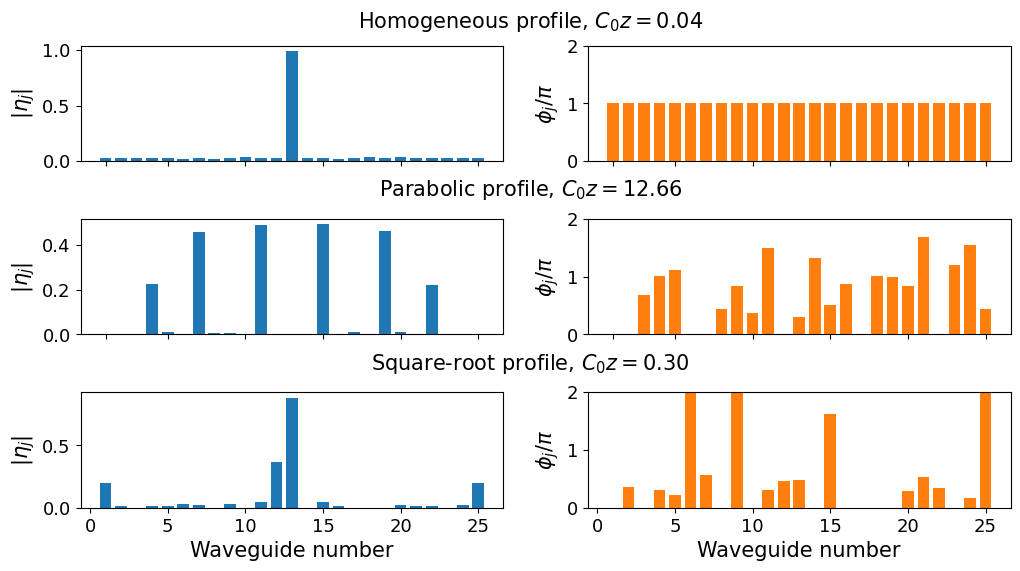

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

waveguide_number = np.linspace(1, N, N)
axes[0, 0].bar(waveguide_number, pump_amp_homo, width=0.75)
axes[0, 1].bar(waveguide_number, pump_pha_homo / np.pi, width=0.75, color='C1')
axes[1, 0].bar(waveguide_number, pump_amp_para, width=0.75)
axes[1, 1].bar(waveguide_number, pump_pha_para / np.pi, width=0.75, color='C1')
axes[2, 0].bar(waveguide_number, pump_amp_sqrt, width=0.75)
axes[2, 1].bar(waveguide_number, pump_pha_sqrt / np.pi, width=0.75, color='C1')

xticks = [1, 5, 10, 15, 20, 25]

for j, ax in enumerate(axes.flatten()):
  ax.tick_params(axis='x', labelsize=13)
  ax.tick_params(axis='y', labelsize=13)
  if j % 2 == 0:
    ax.set_ylabel('$|\\eta_j|$', fontsize=15)
  else:
    ax.set_ylabel('$\\phi_j / \\pi$', fontsize=15)
    ax.set_ylim(0, 2)
  if j < 4:
    ax.set_xticks(xticks, [])
  else:
    ax.set_xlabel('Waveguide number', fontsize=15)

plt.figtext(0.5, 0.92, f'Homogeneous profile, $C_0z=${z_homo:.2f}', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.64, f'Parabolic profile, $C_0z=${z_para:.2f}', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.35, f'Square-root profile, $C_0z=${z_sqrt:.2f}', fontsize=15, ha='center', va='center')

fig.subplots_adjust(hspace=0.5)  # Set custom spacing
plt.show()

Figure 12S

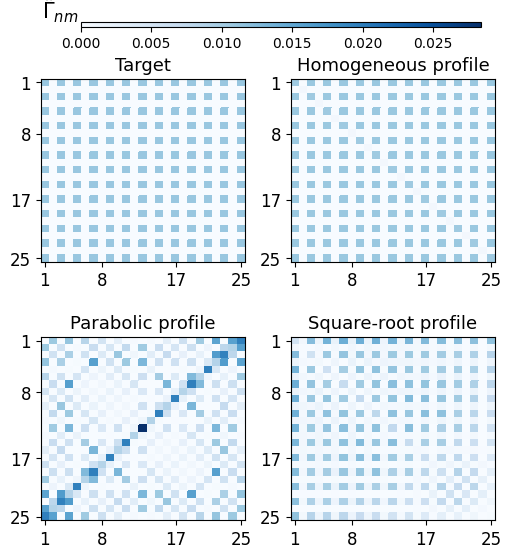

In [ ]:
fig = plt.figure(figsize=(5, 5), layout="constrained")
spec = fig.add_gridspec(2, 2, hspace=0.10)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[1, 1])

vmax = max(corr_ideal.max(), corr_homo.max(), corr_para.max())
pc1 = ax0.pcolor(corr_ideal, vmin=0, vmax=vmax, cmap='Blues')
cbar_ax = fig.add_axes([0.15, 1.05, 0.8, 0.01])
cbar = fig.colorbar(pc1, cax=cbar_ax, orientation='horizontal')
pc2 = ax1.pcolor(corr_homo, vmin=0, vmax=vmax, cmap='Blues')
pc3 = ax2.pcolor(corr_para, vmin=0, vmax=vmax, cmap='Blues')
pc3 = ax3.pcolor(corr_sqrt, vmin=0, vmax=vmax, cmap='Blues')

xticks = np.array([0.5, round(N/3) - 0.5, round(2*N/3) - 0.5, N - 0.5])
xlabels = np.array([1, round(N/3), round(2*N/3), N])

for i, ax in enumerate([ax0, ax1, ax2, ax3]):
  ax.set_yticks(xticks, xlabels, fontsize=12)
  ax.set_xticks(xticks, xlabels, fontsize=12)

ax0.set_title('Target', fontsize=13)
ax1.set_title('Homogeneous profile', fontsize=13)
ax2.set_title('Parabolic profile', fontsize=13)
ax3.set_title('Square-root profile', fontsize=13)
for axis in [ax0, ax1, ax2, ax3]: axis.yaxis.set_inverted(True)
cbar.ax.tick_params(axis='y', labelsize=11)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('$\\tilde{{\Gamma}}_{{nm}}$', rotation=0, fontsize=15)

plt.show()